# Census Bureau Income Data EDA

This notebook performs exploratory data analysis on the Census Bureau Income dataset.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# Set plot style
plt.style.use('default')
sns.set_theme()

# Create visualization directory
VIZ_DIR = Path('outputs/visualizations')
VIZ_DIR.mkdir(parents=True, exist_ok=True)

## Data Loading and Initial Inspection

In [3]:
# Load column names
DATA_PATH = Path('..') / 'data'
RAW_COLS_FILE = DATA_PATH / 'census-bureau.columns'
RAW_DATA_FILE = DATA_PATH / 'census-bureau.data'

# Read column names
cols = pd.read_csv(RAW_COLS_FILE, header=None, names=['col'])['col'].str.strip().tolist()

# Load data
df = pd.read_csv(RAW_DATA_FILE, header=None, names=cols)

# Display basic information
print('Dataset Shape:', df.shape)
print('\nDataset Info:')
df.info()

Dataset Shape: (199523, 42)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code      

## Target Variable Analysis

Unique values in target column:
label
- 50000.    187141
50000+.      12382
Name: count, dtype: int64

Target Distribution:
label_bin
0.0    0.9379
1.0    0.0621
Name: proportion, dtype: float64

Target Distribution:
label_bin
0.0    0.9379
1.0    0.0621
Name: proportion, dtype: float64


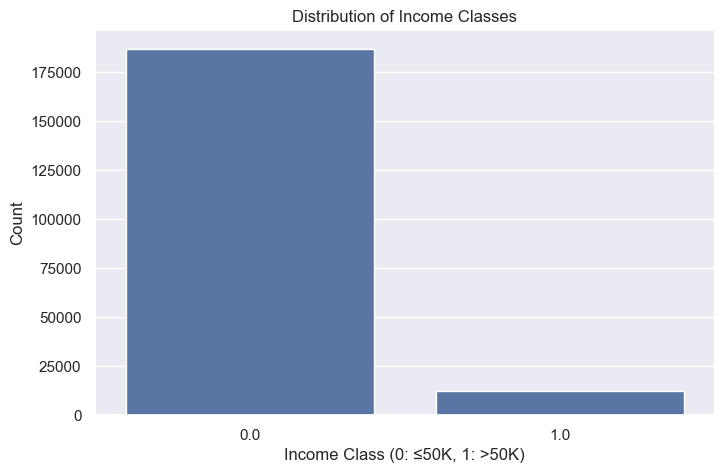

In [4]:
# Display unique values in target column
print('Unique values in target column:')
print(df['label'].value_counts())

# Create binary target (without modifying original label)
target_map = {'- 50000.': 0, ' - 50000.': 0, '50000+.': 1, ' 50000+.': 1}

def _norm_key(s):
    s = "" if pd.isna(s) else str(s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Normalize keys in the provided map
_target_map_norm = {_norm_key(k): v for k, v in target_map.items()}

# Map target values (keep original label column)
df['label_bin'] = df['label'].map(lambda x: _target_map_norm.get(_norm_key(x), np.nan)).astype('float')

# Show target distribution
print('\nTarget Distribution:')
print(df['label_bin'].value_counts(normalize=True).round(4))

# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label_bin')
plt.title('Distribution of Income Classes')
plt.xlabel('Income Class (0: ≤50K, 1: >50K)')
plt.ylabel('Count')
plt.savefig(VIZ_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Numeric Features Analysis

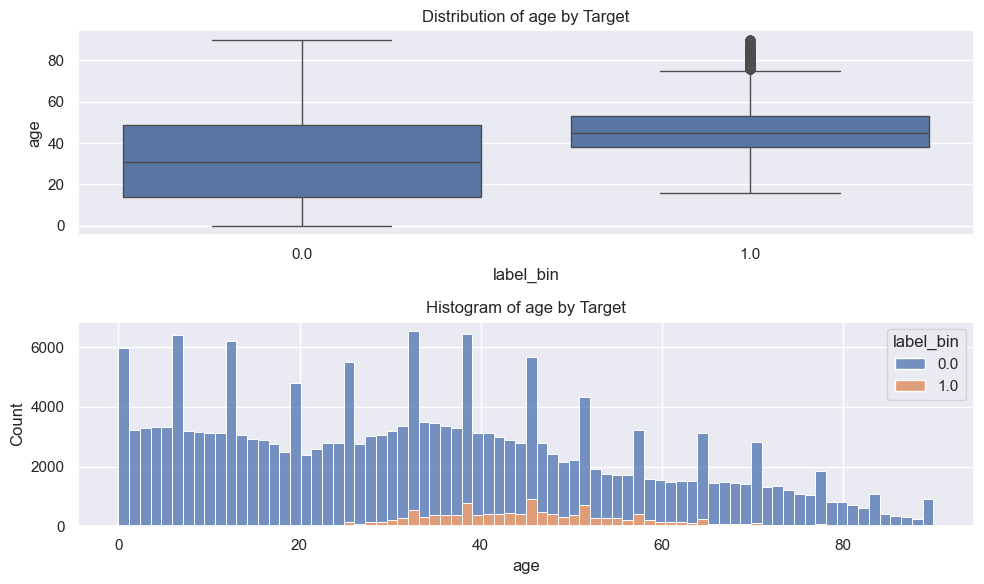

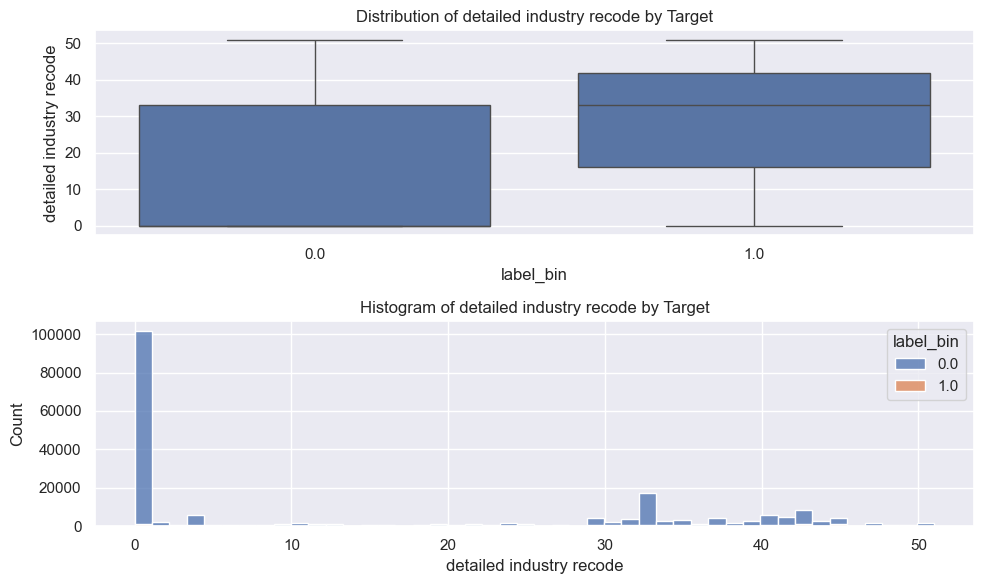

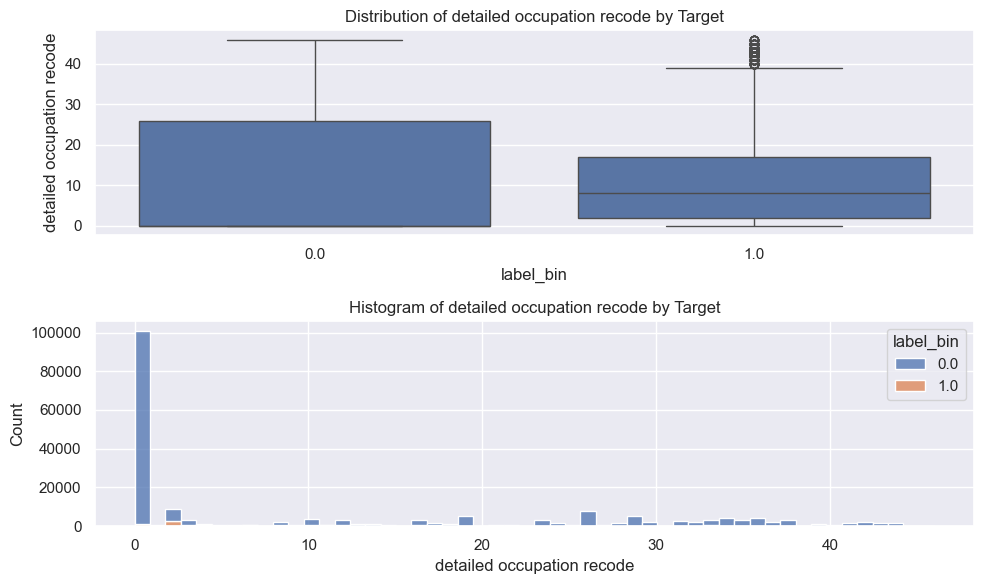

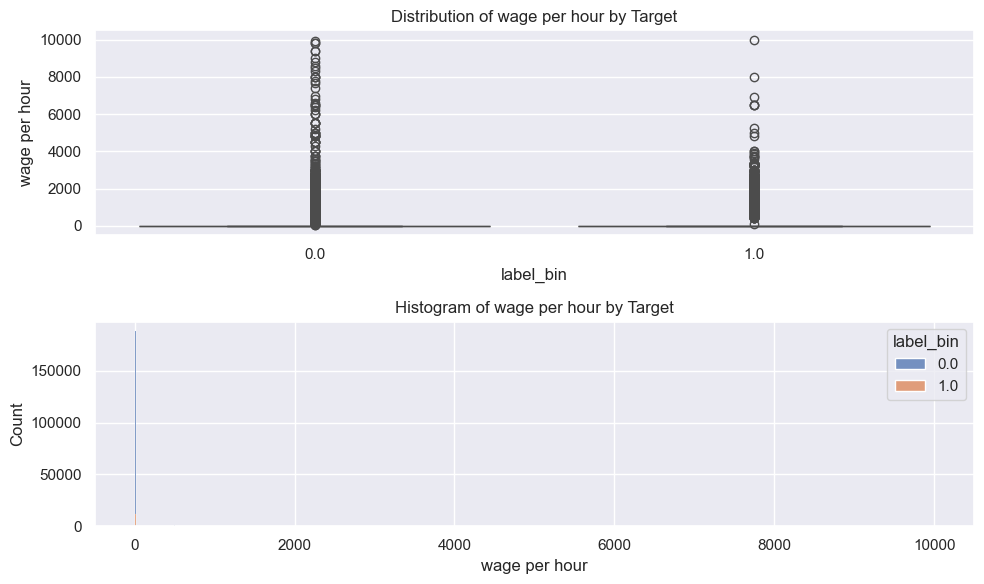

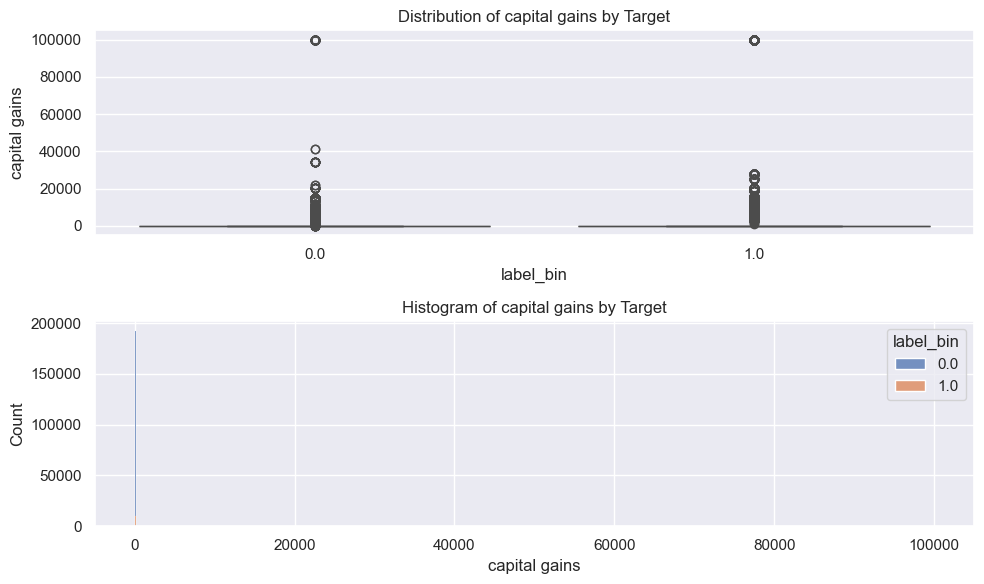

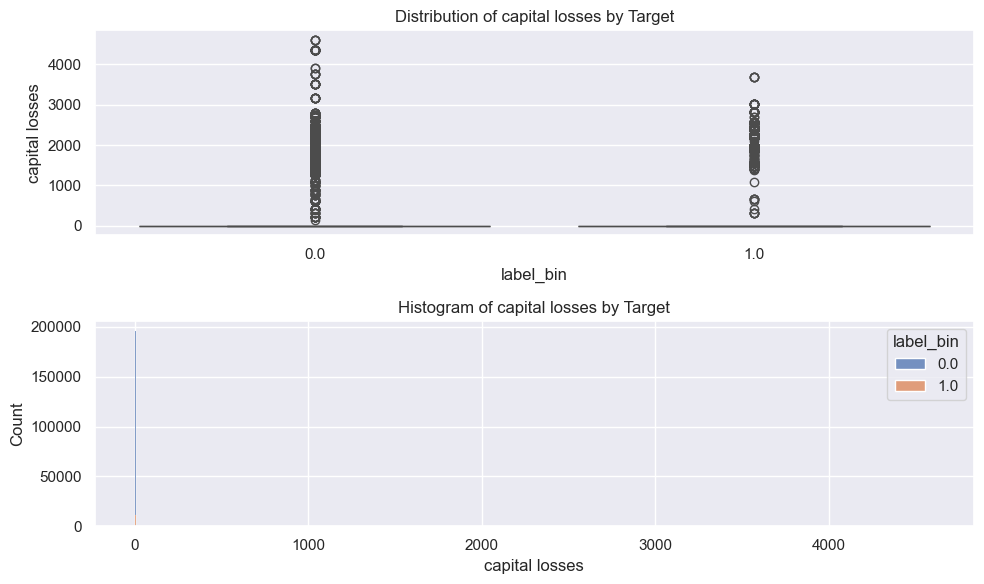

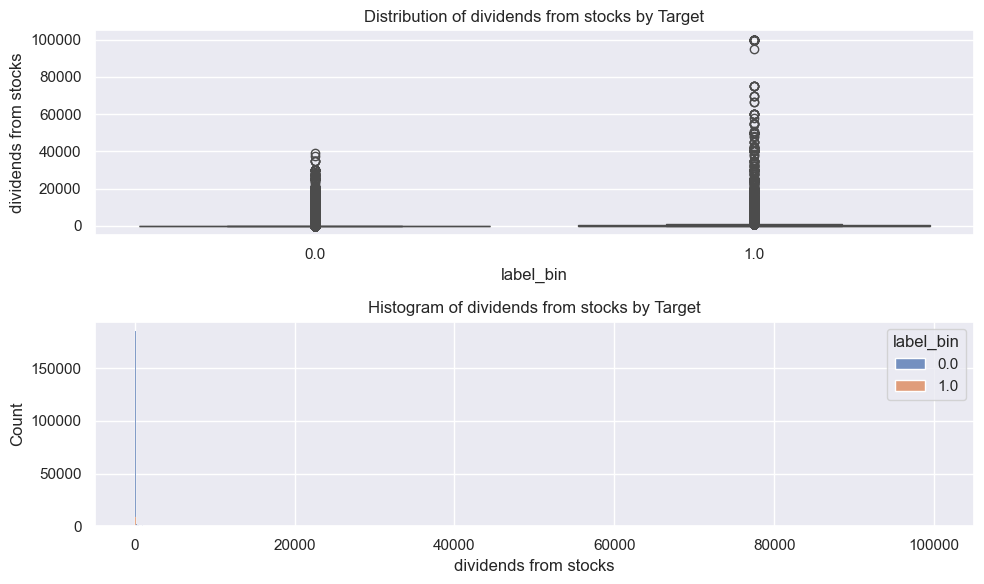

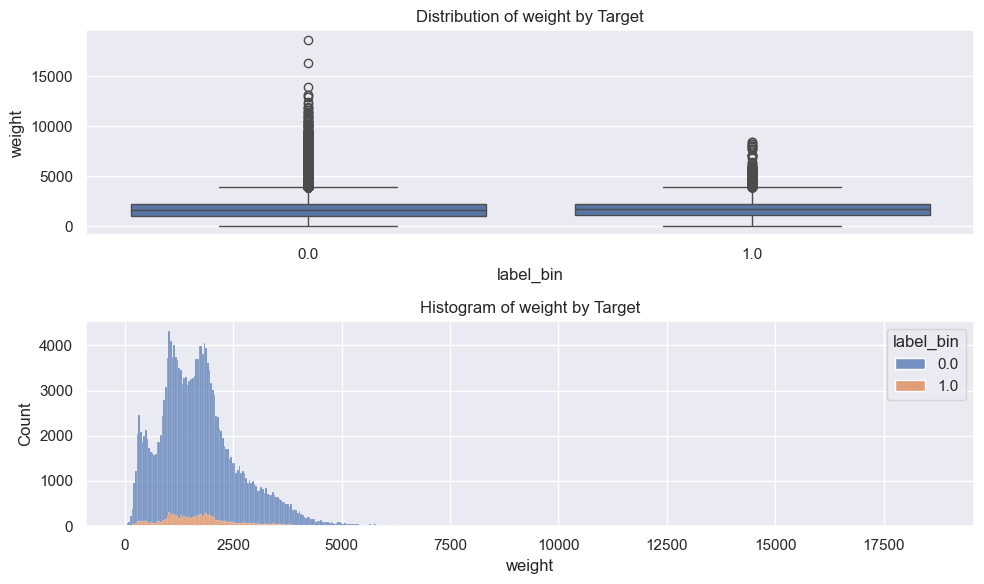

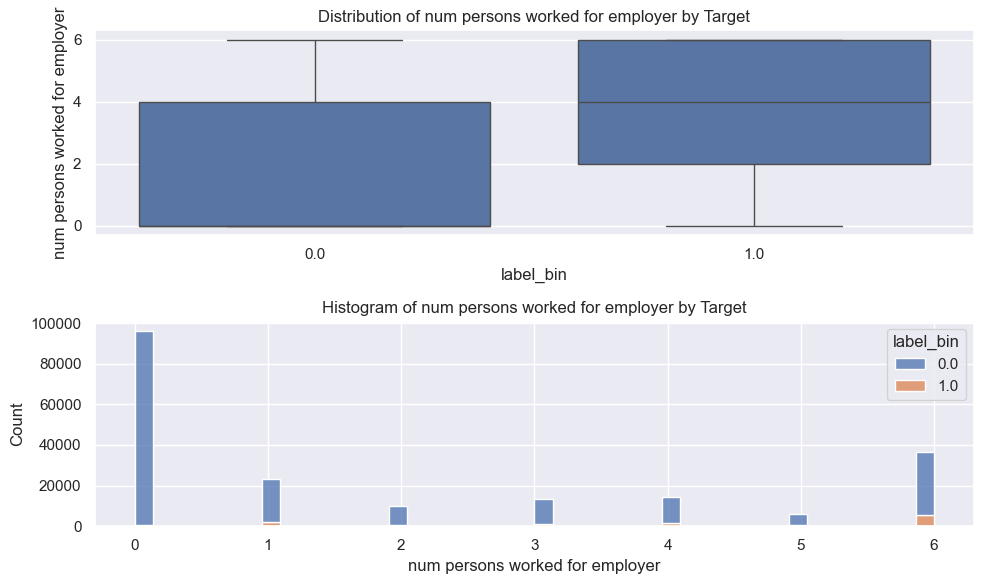

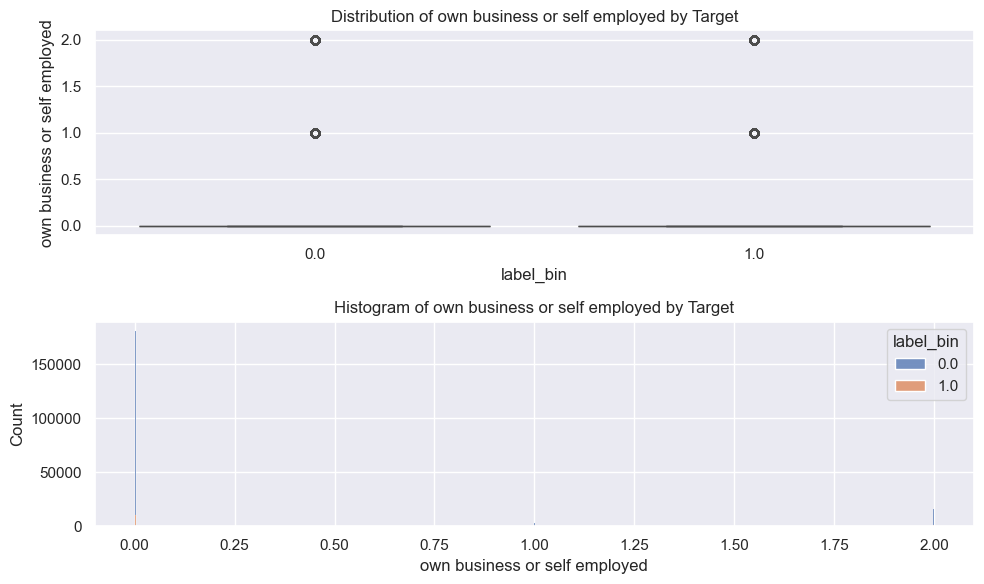

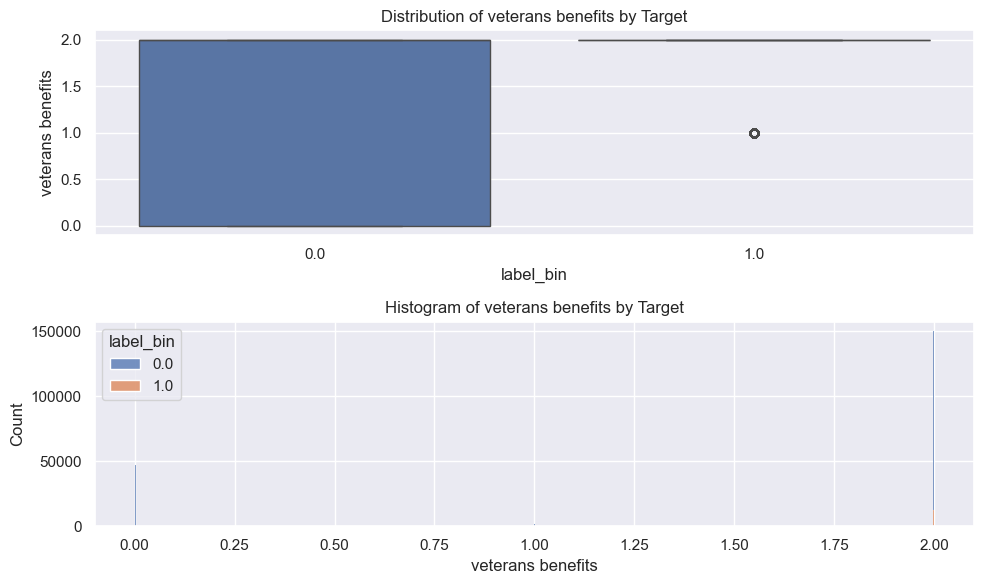

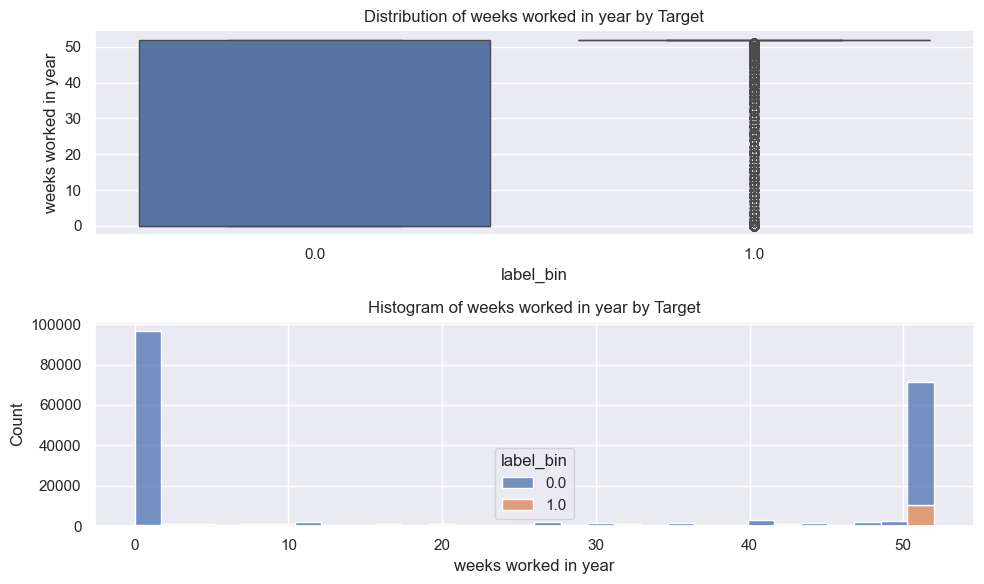

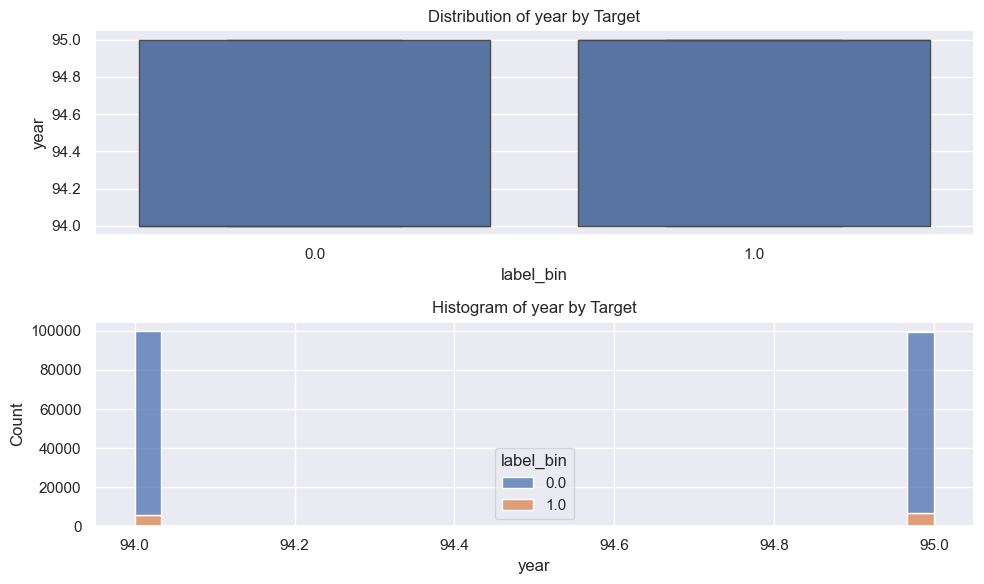

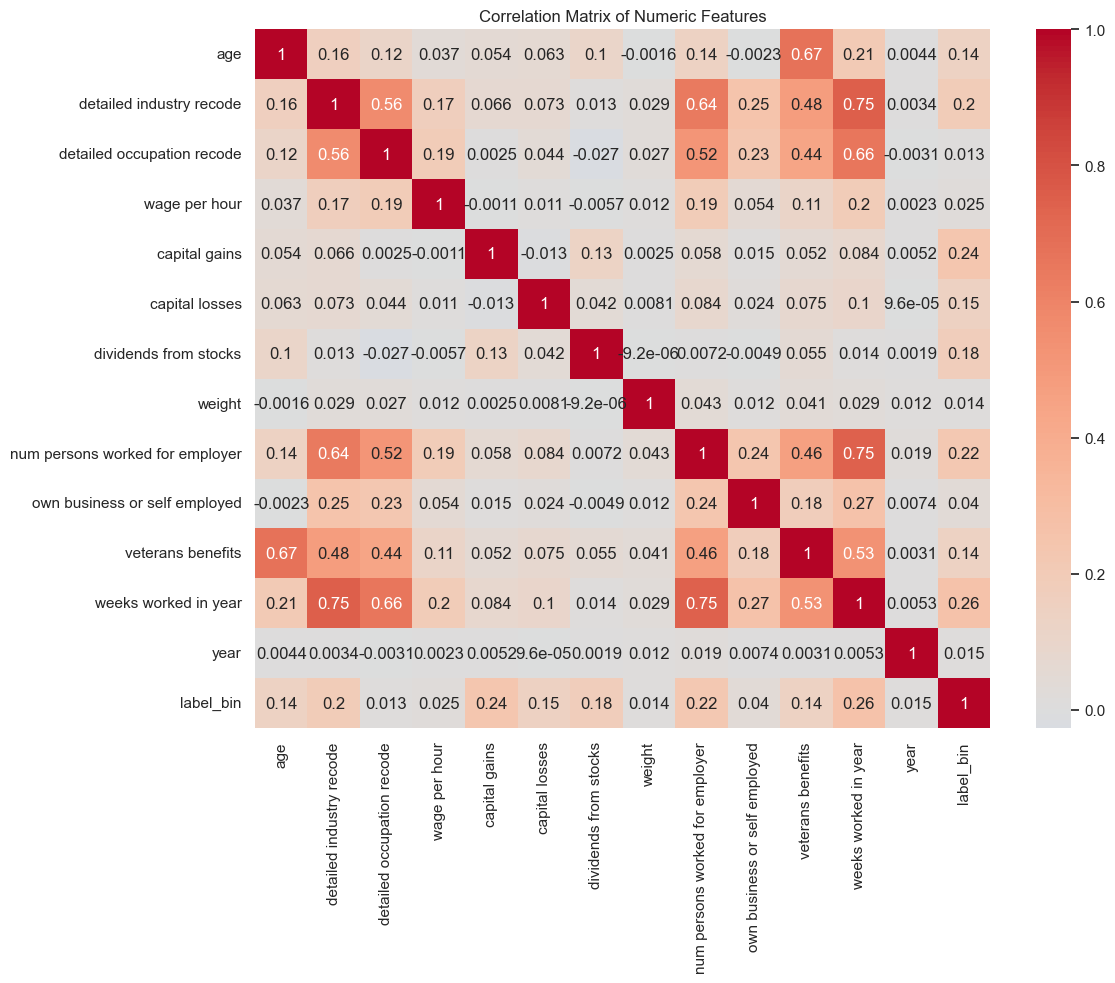

In [5]:
# Select numeric columns (excluding binary target)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('label_bin')

# Create distribution plots for numeric features
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    sns.boxplot(data=df, x='label_bin', y=col)
    plt.title(f'Distribution of {col} by Target')
    
    plt.subplot(2, 1, 2)
    sns.histplot(data=df, x=col, hue='label_bin', multiple='stack')
    plt.title(f'Histogram of {col} by Target')
    
    plt.tight_layout()
    plt.savefig(VIZ_DIR / f'{col}_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Correlation matrix for numeric features
corr_matrix = df[list(numeric_cols) + ['label_bin']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Categorical Features Analysis

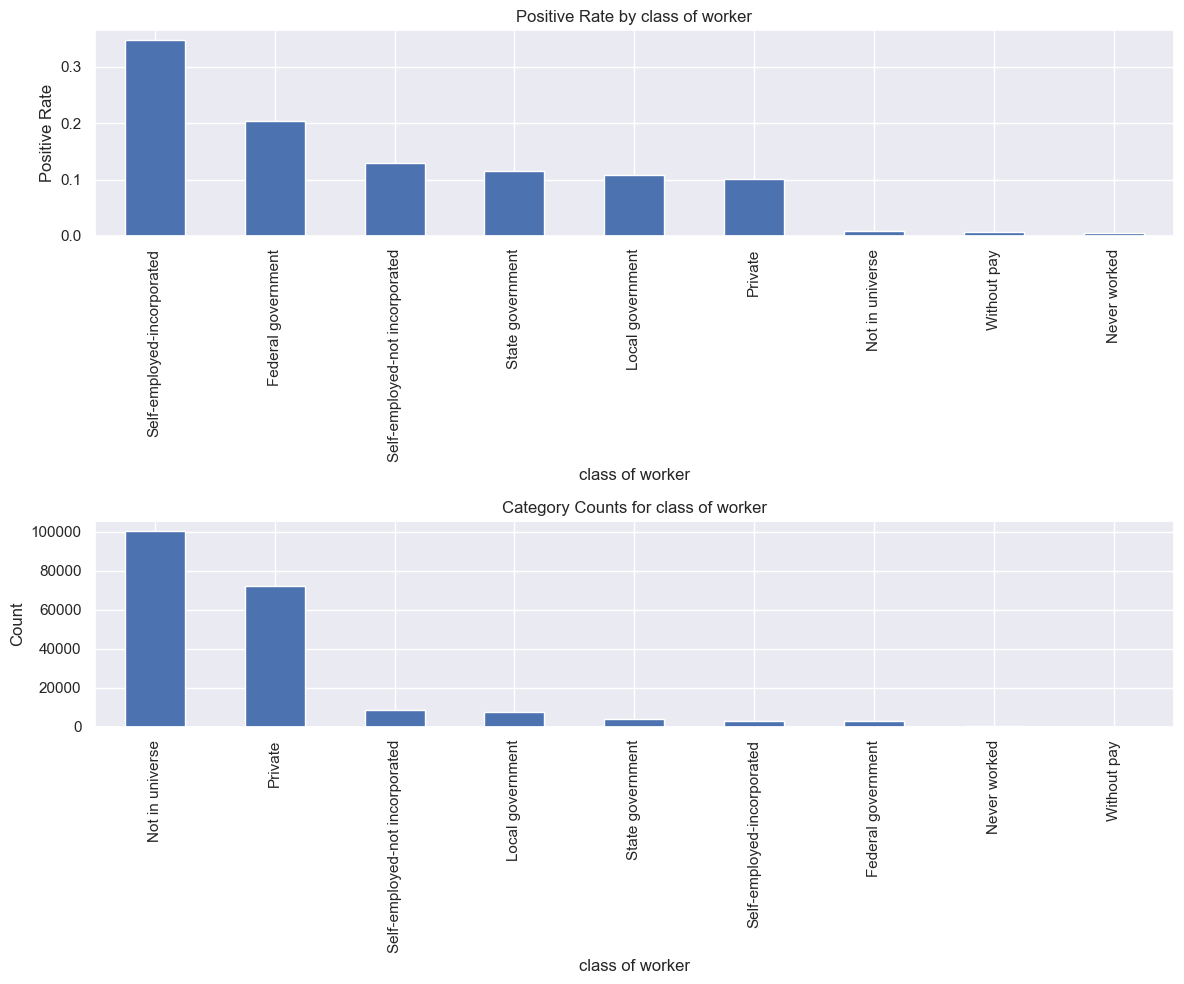

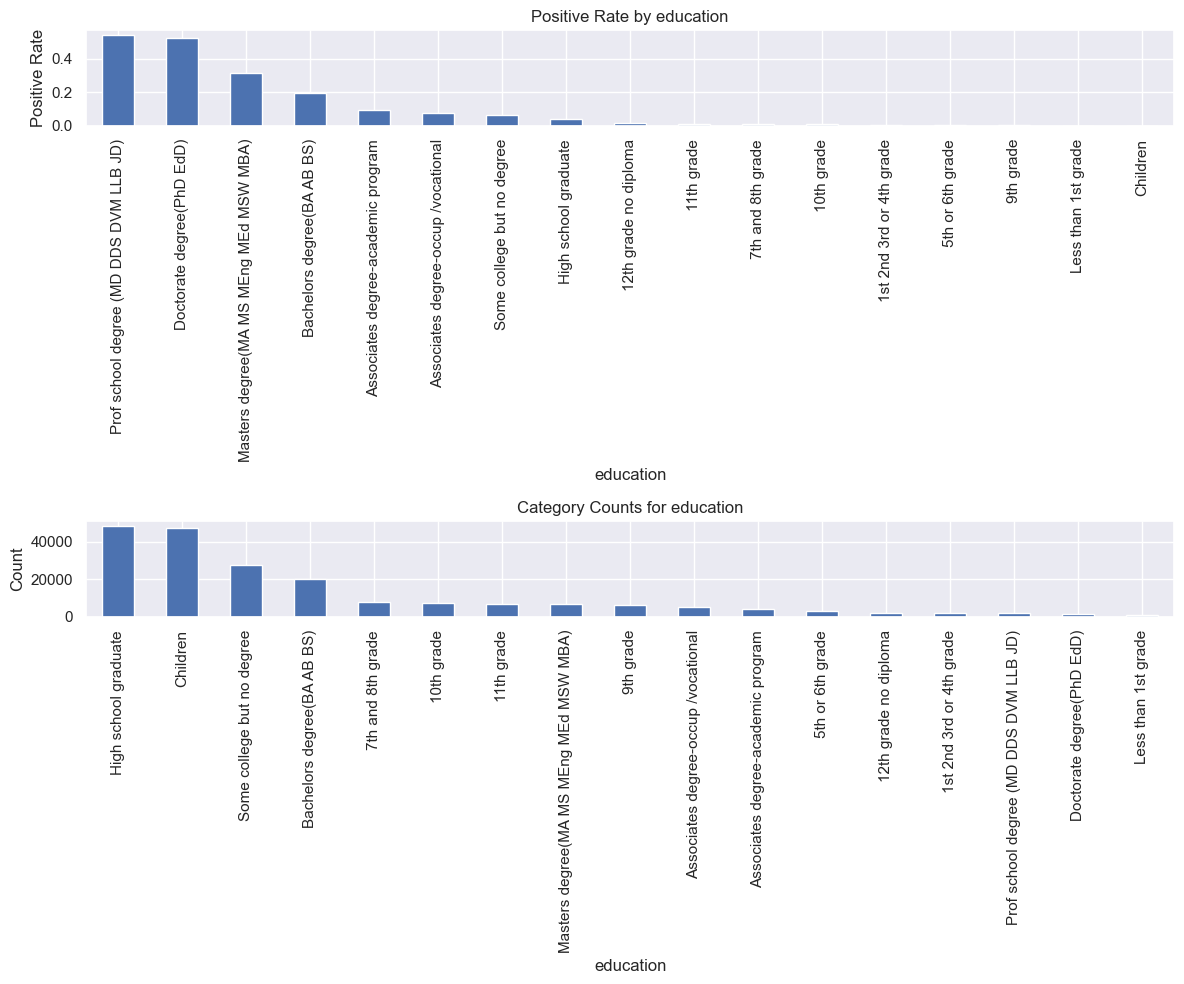

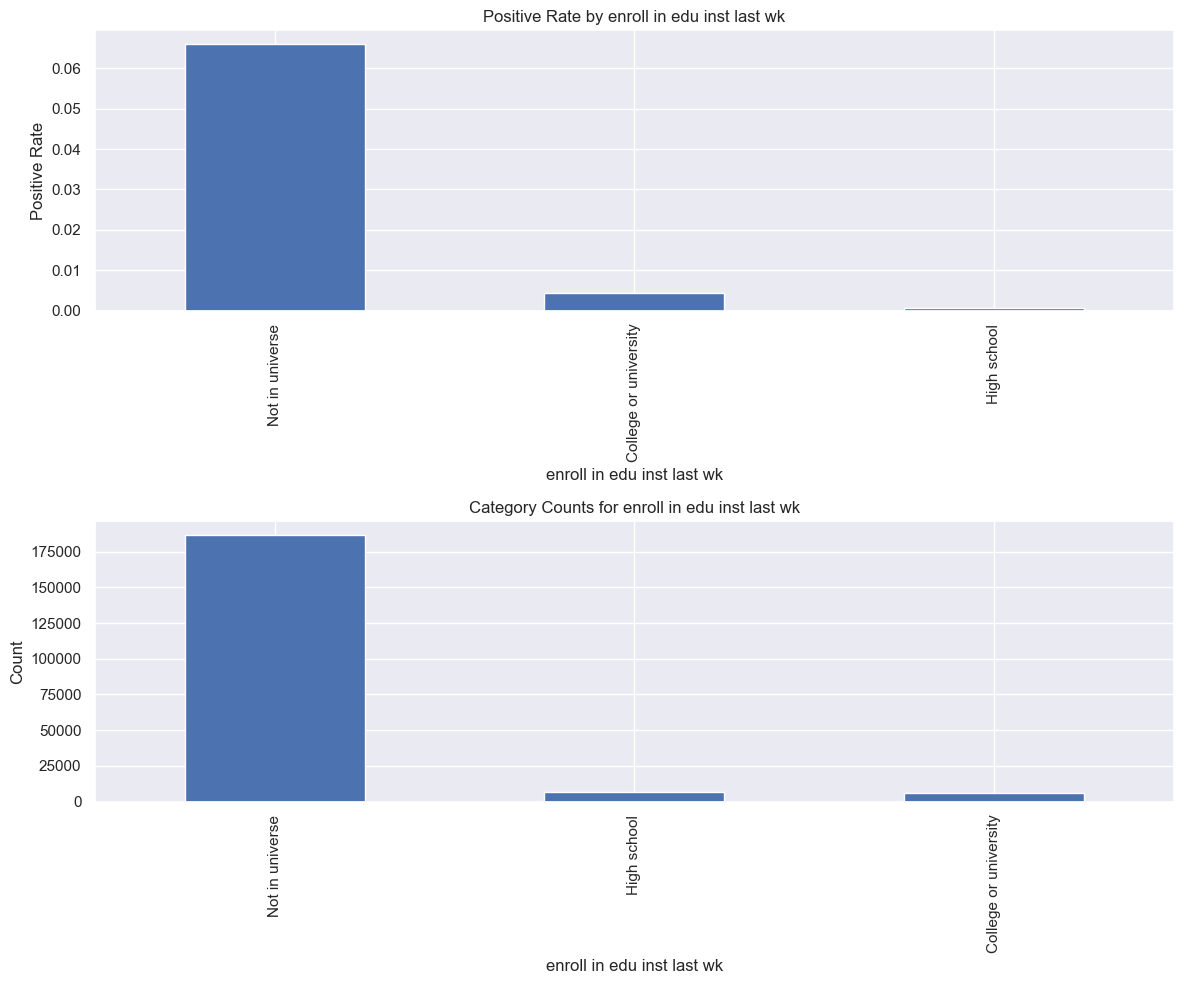

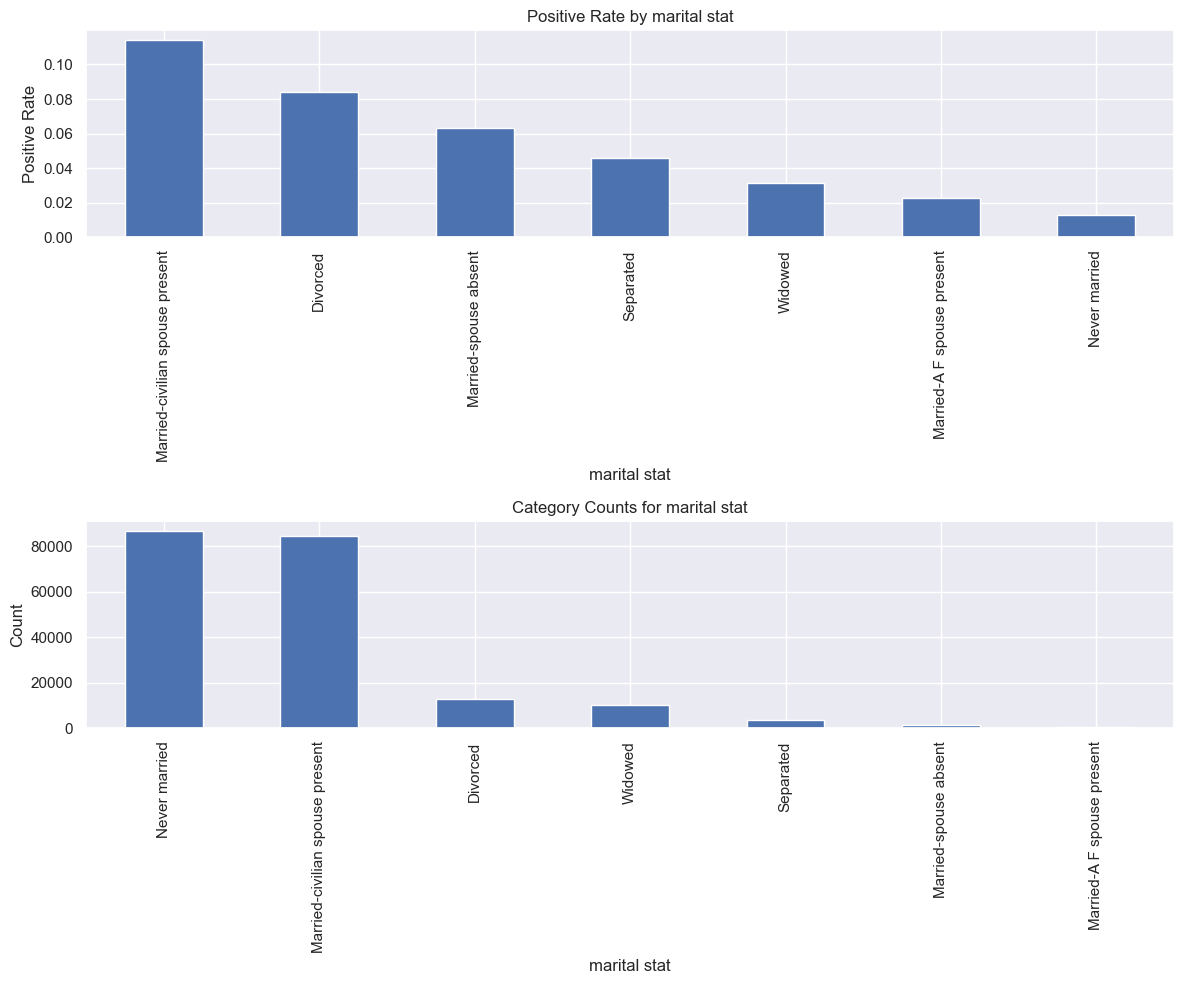

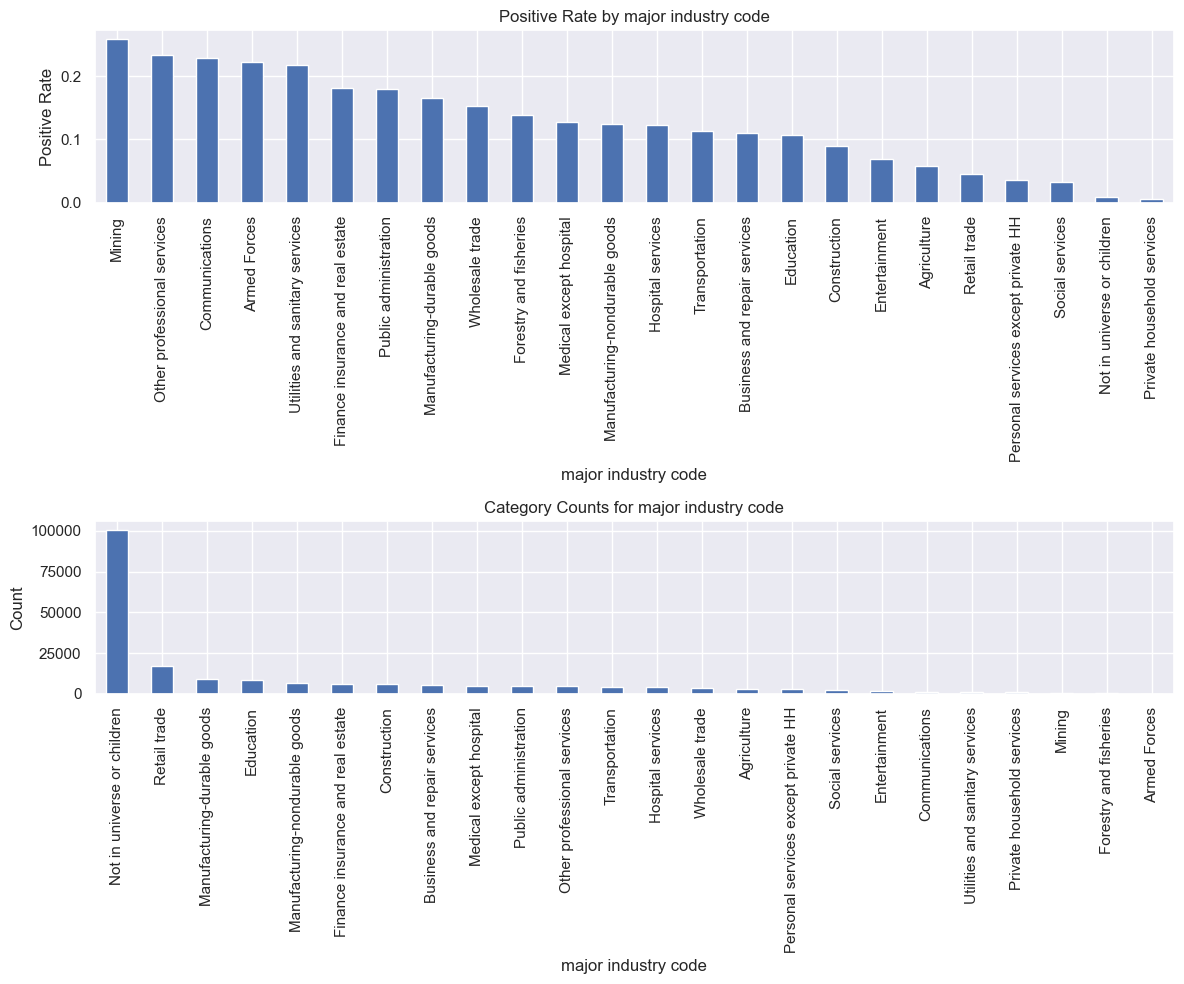

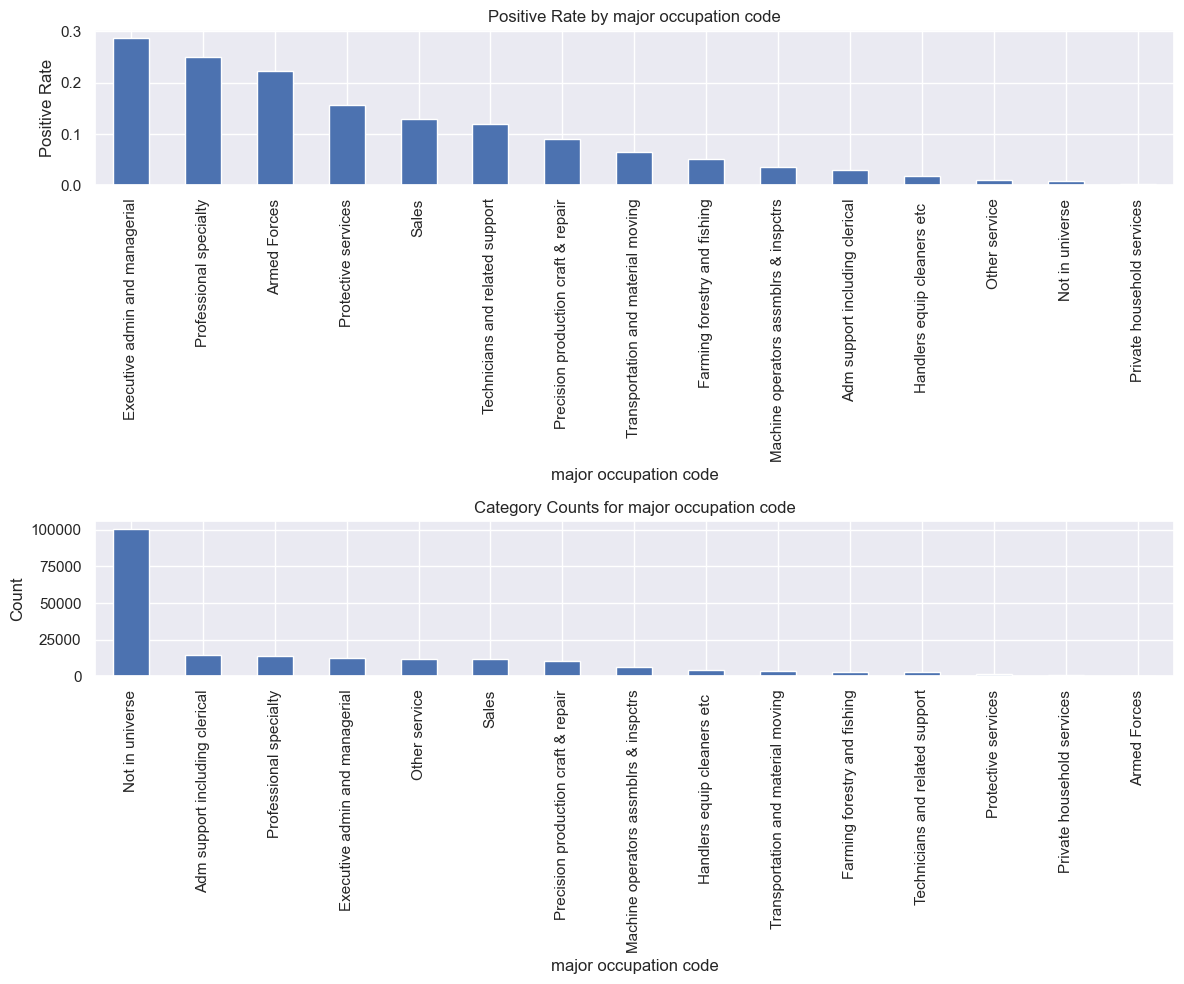

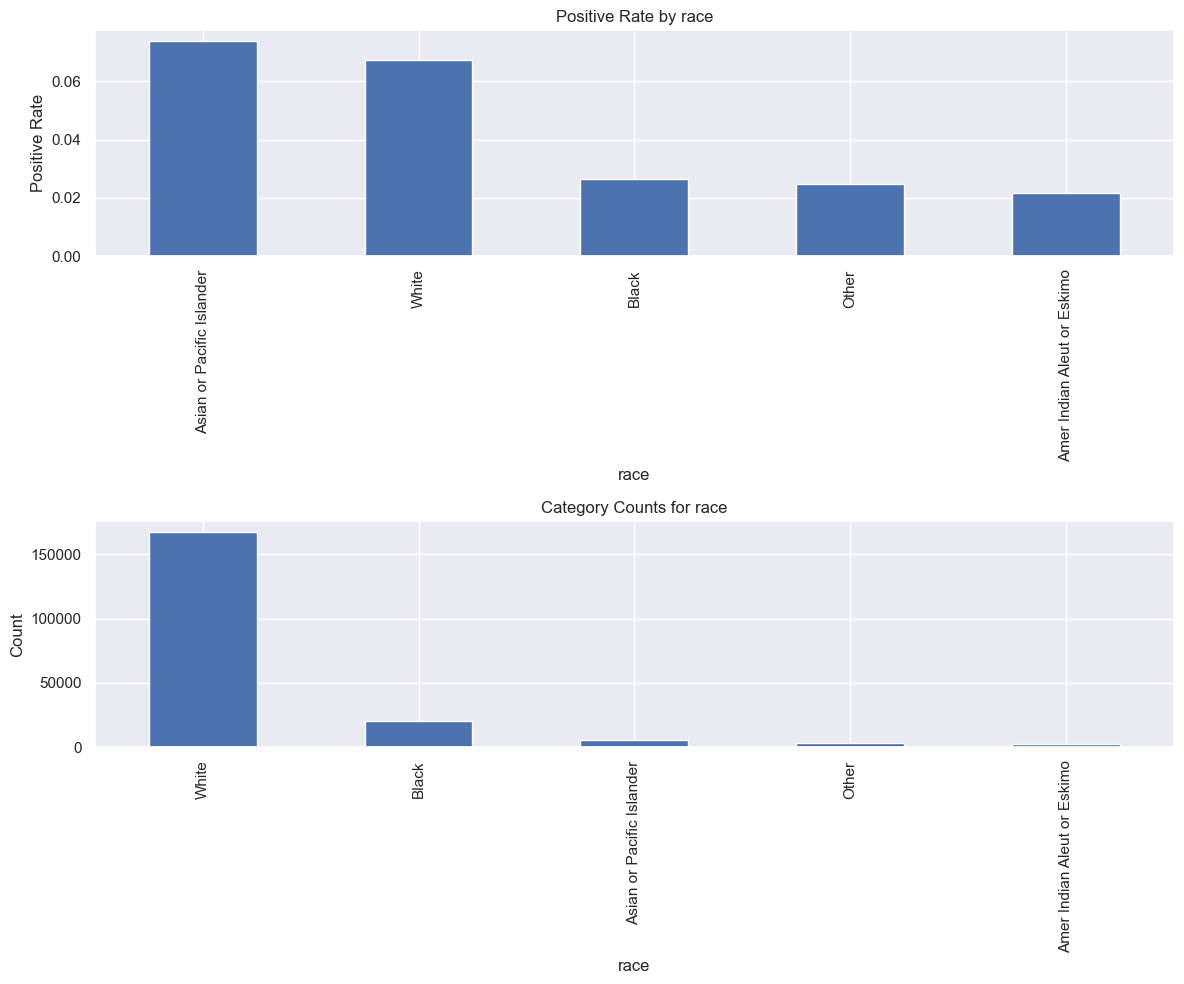

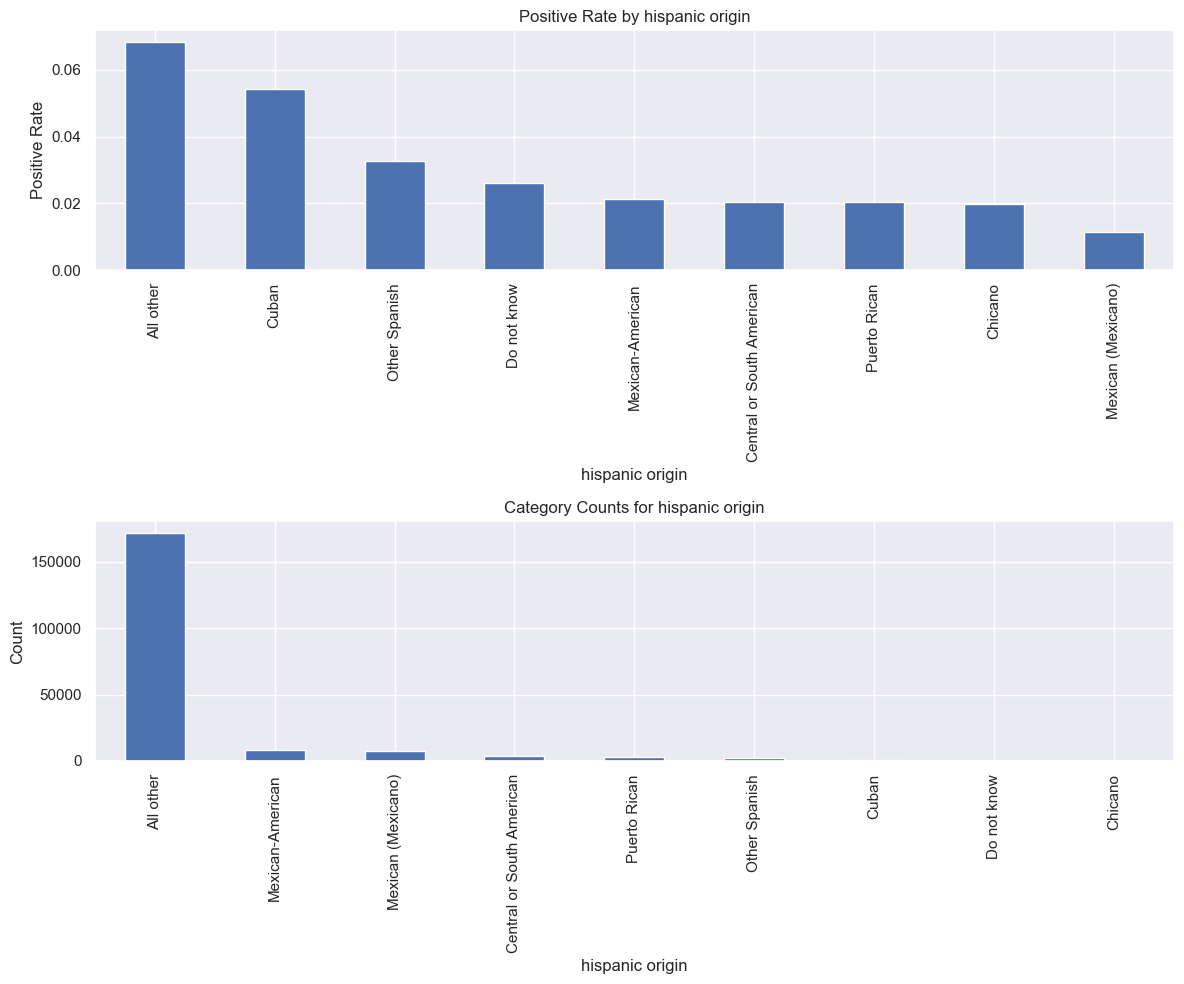

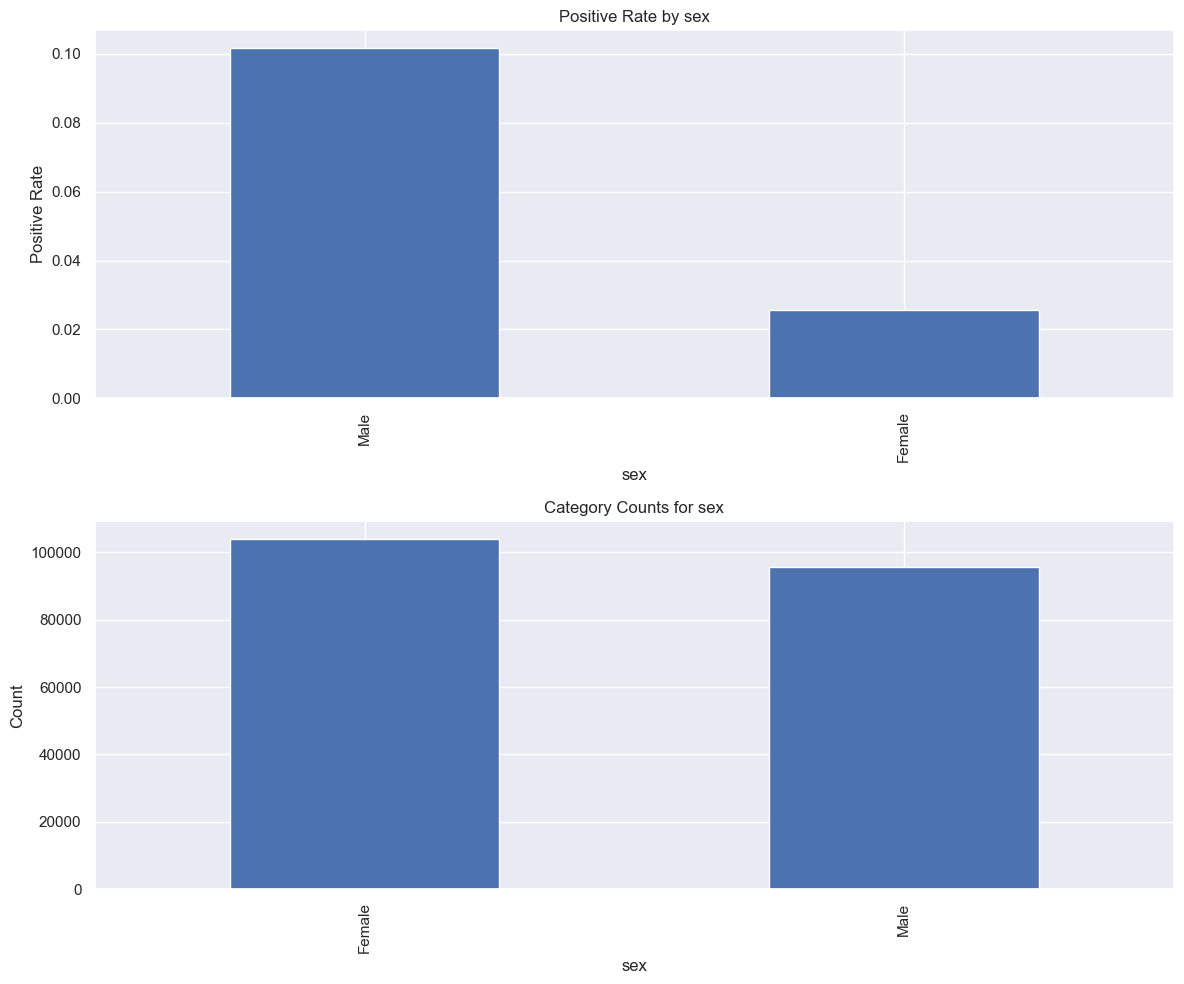

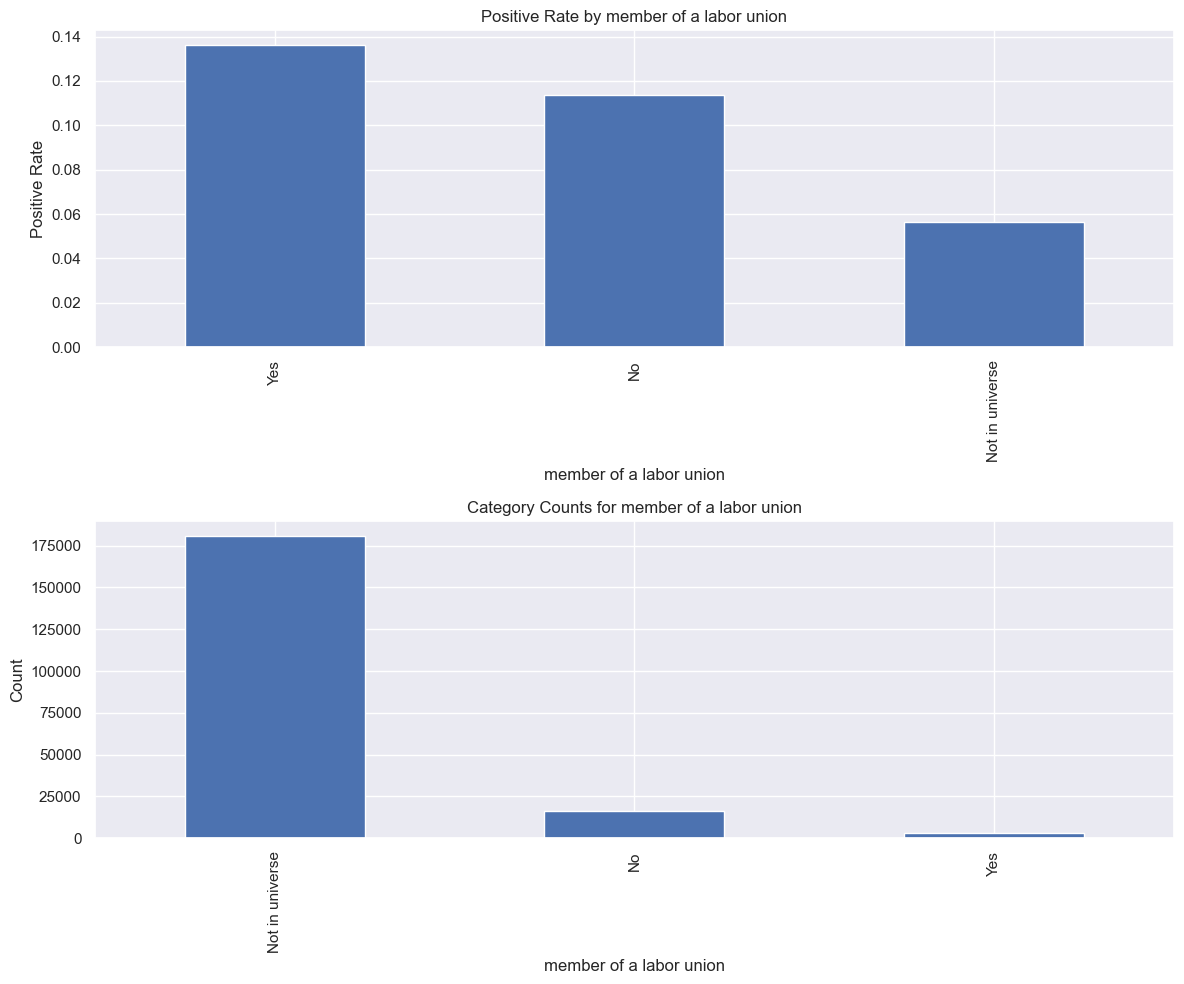

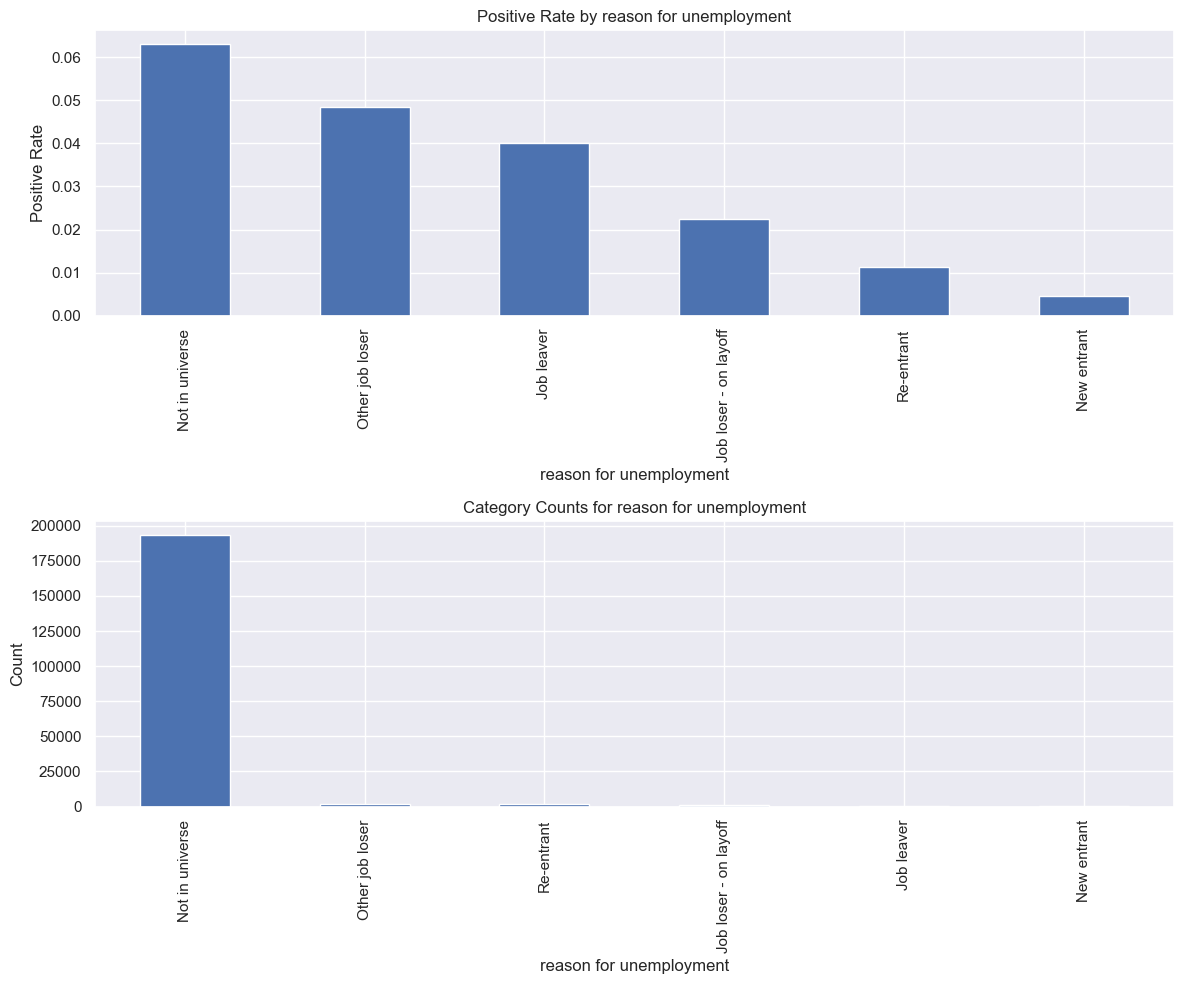

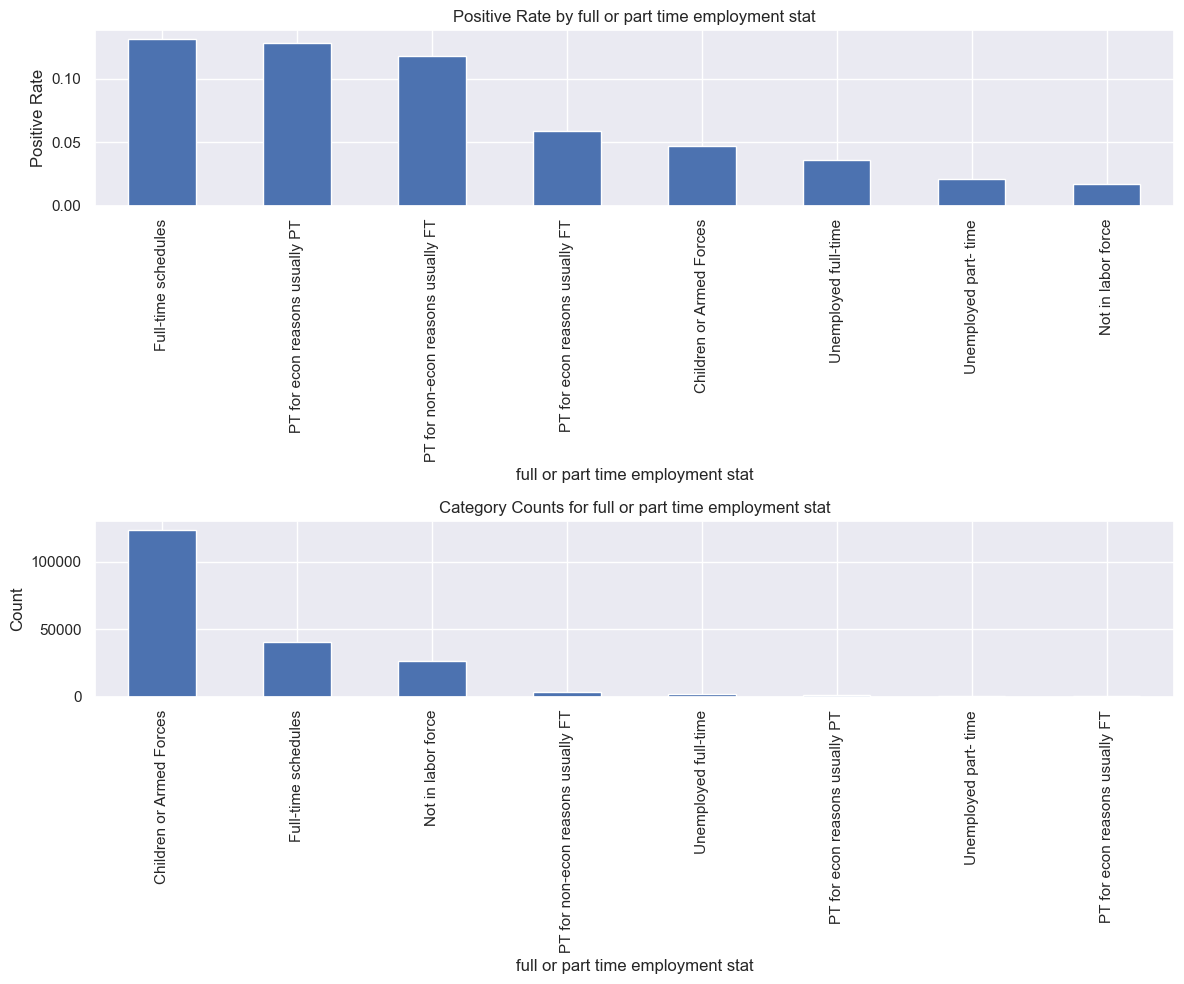

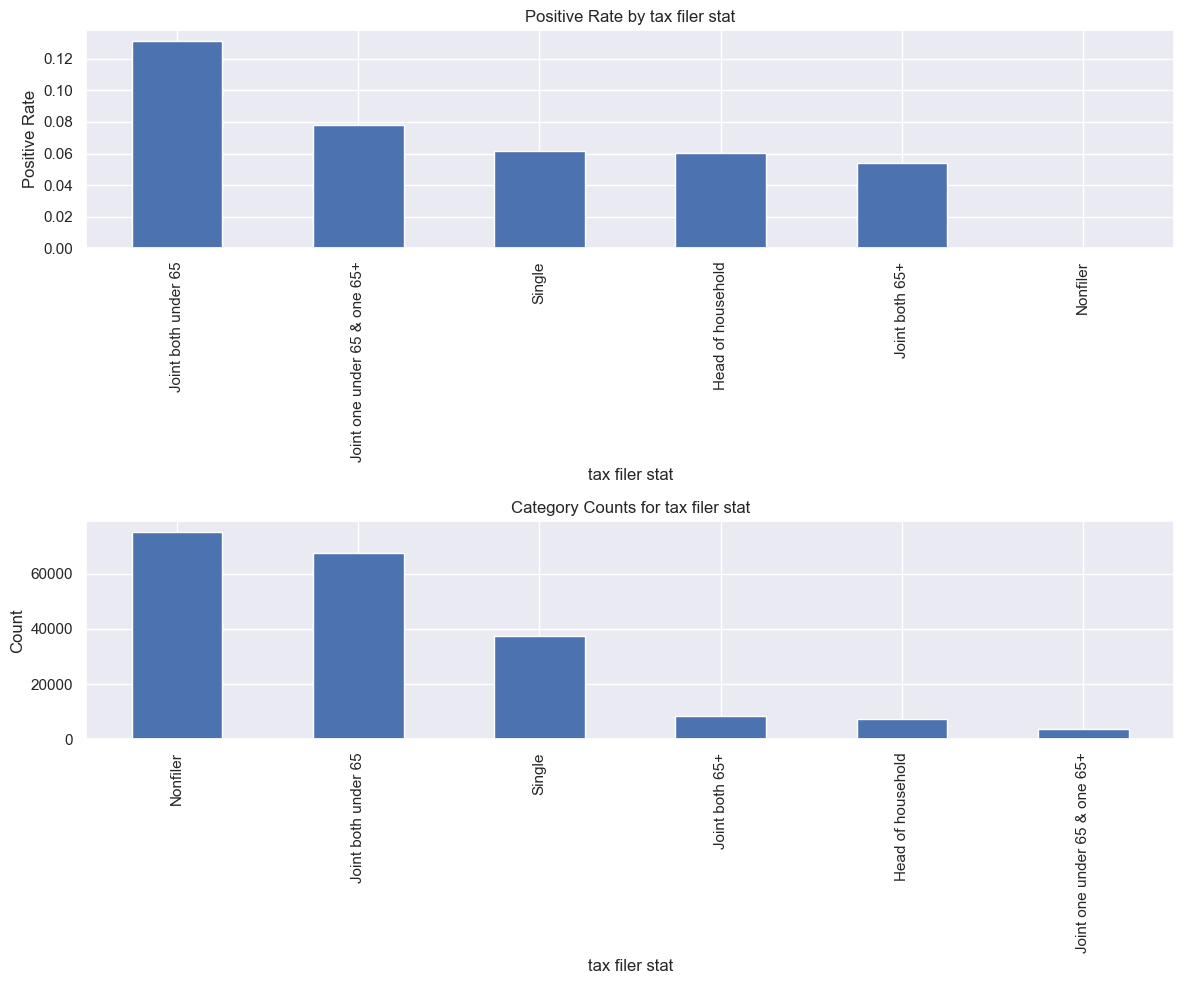

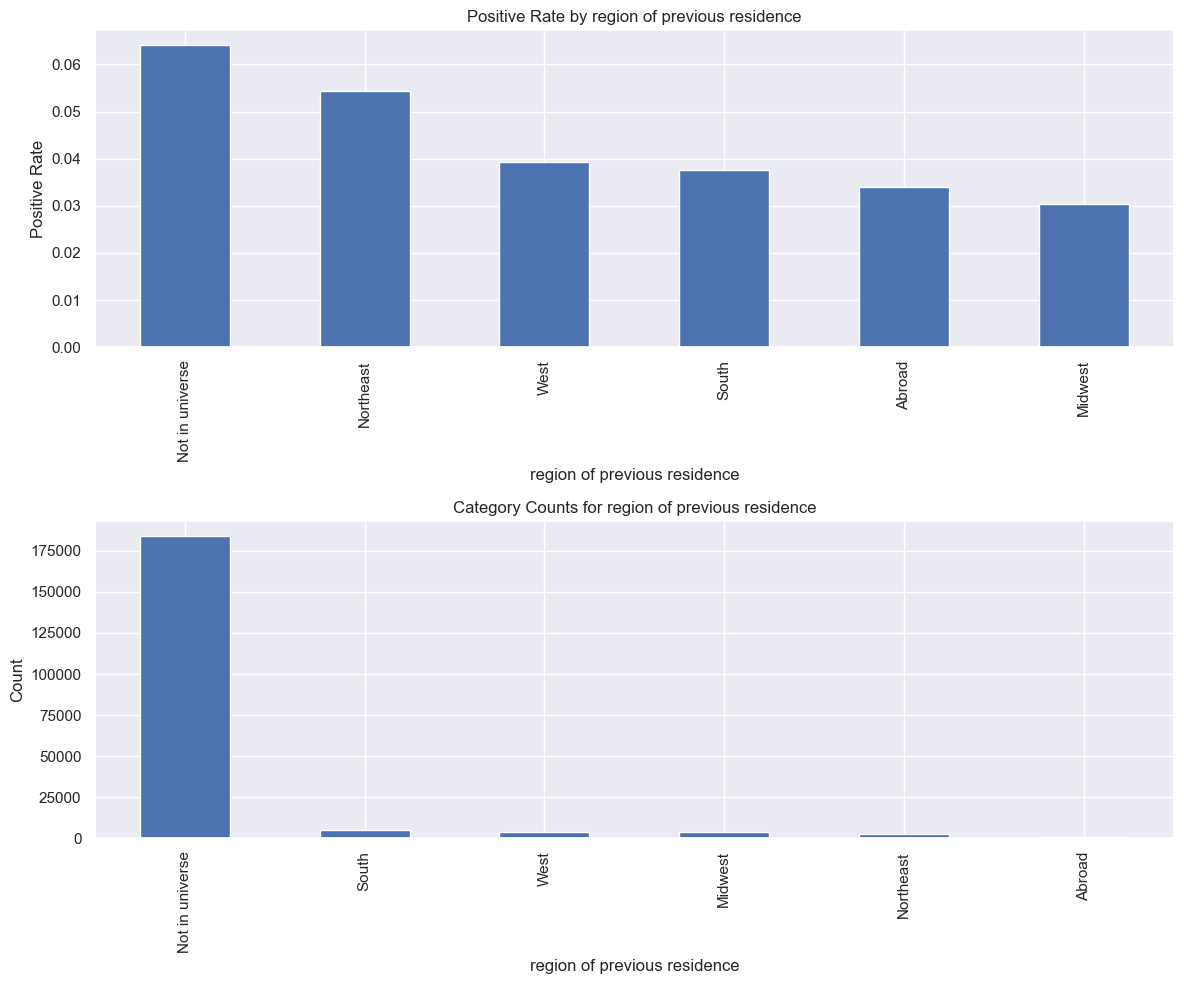

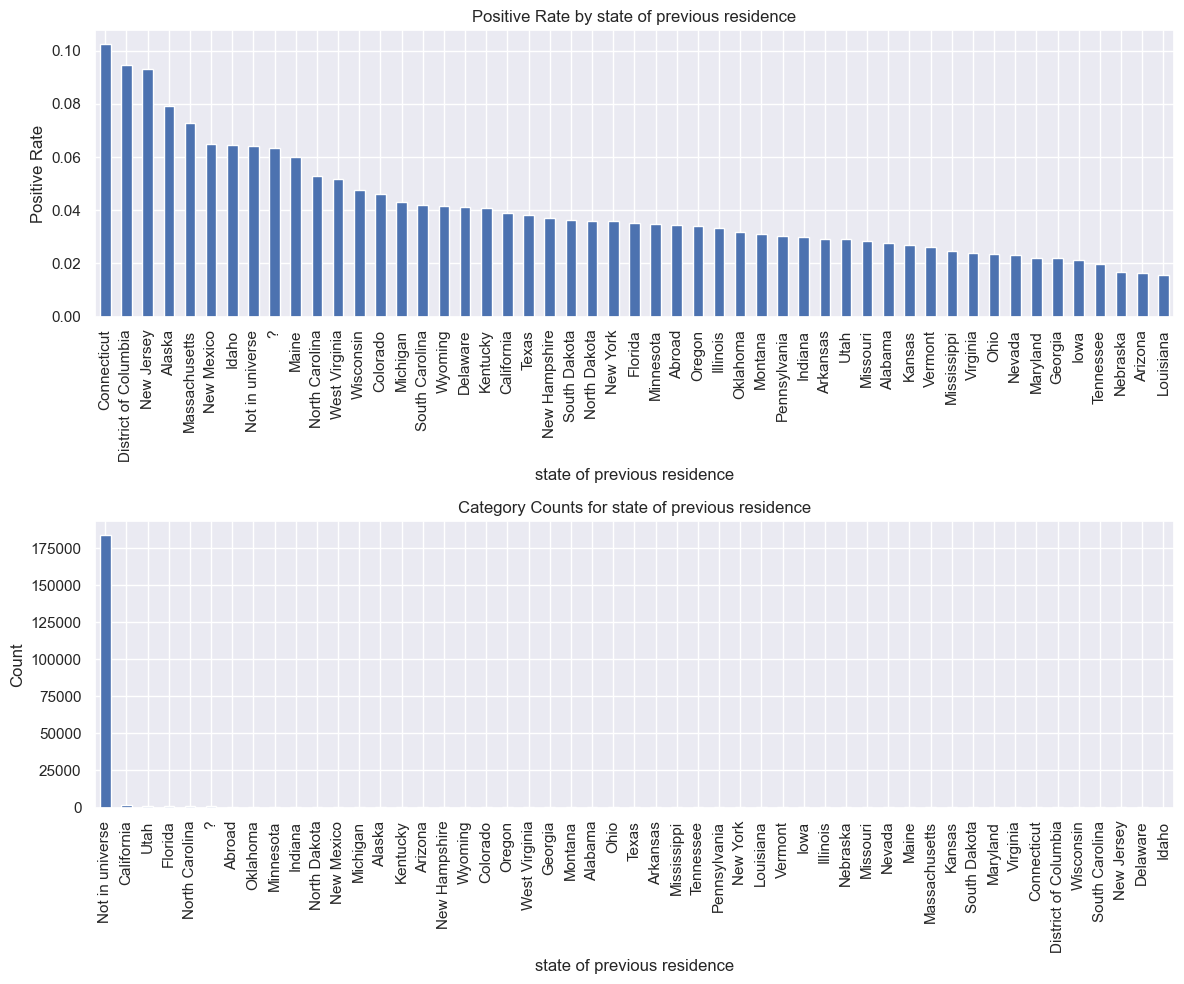

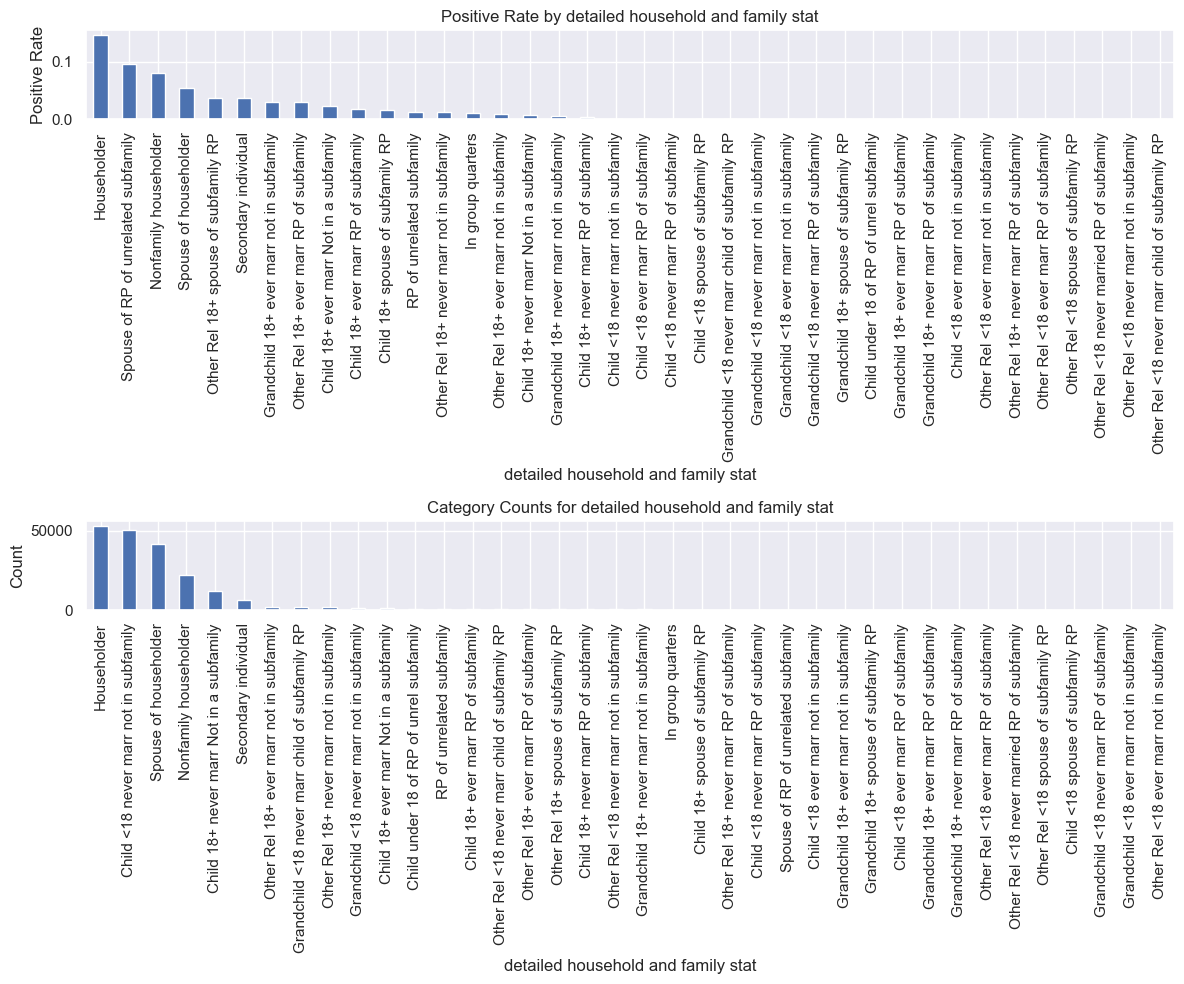

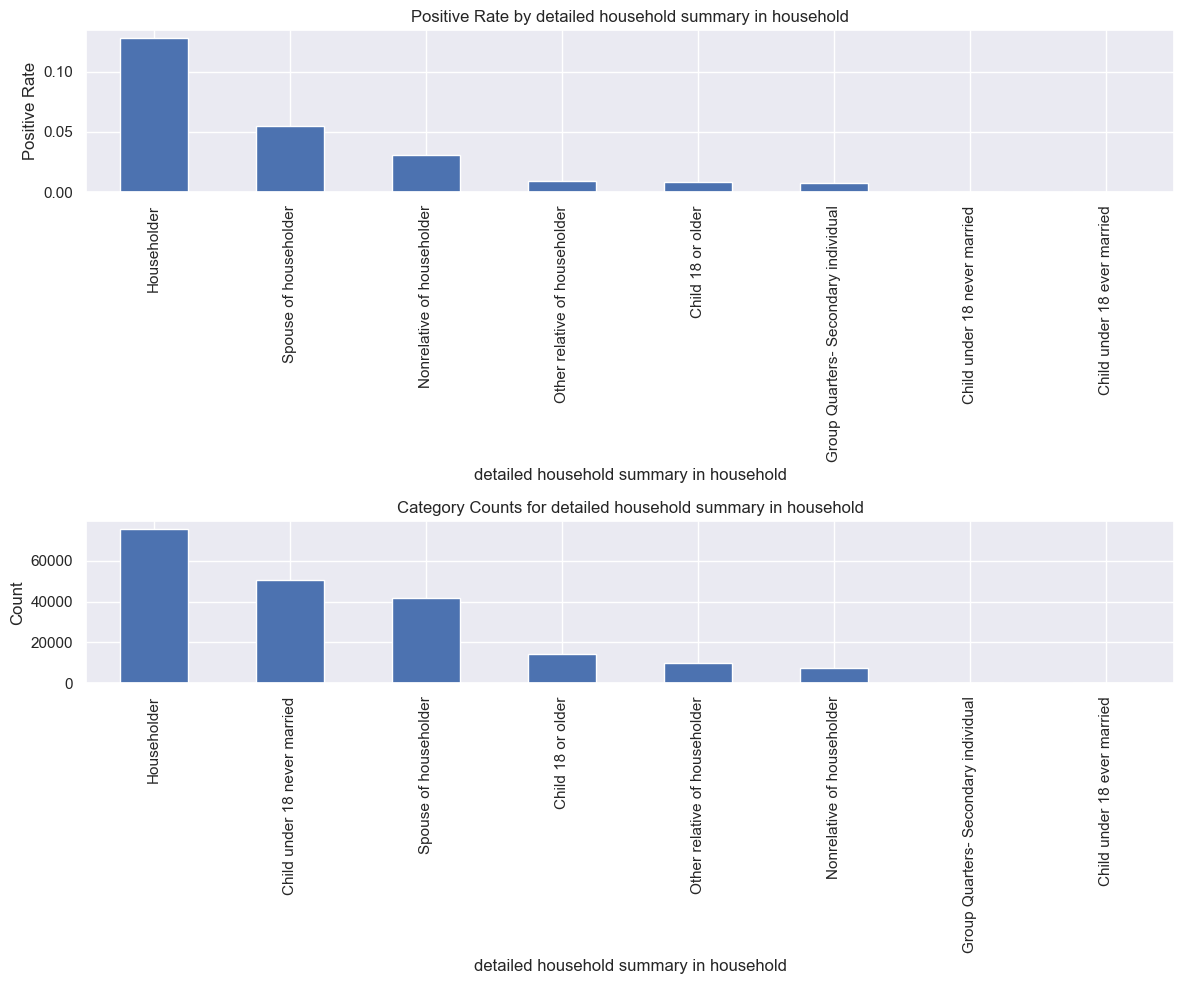

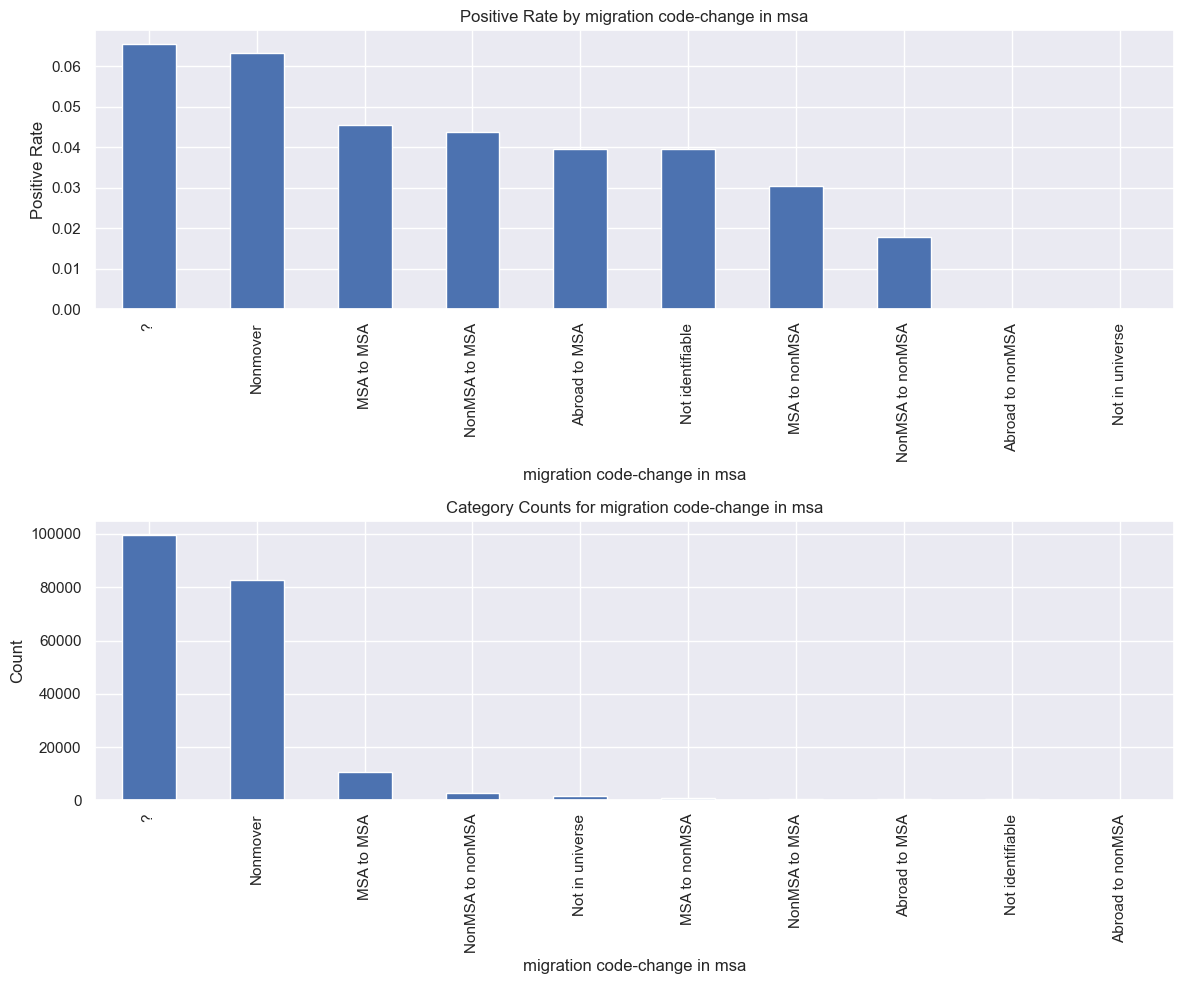

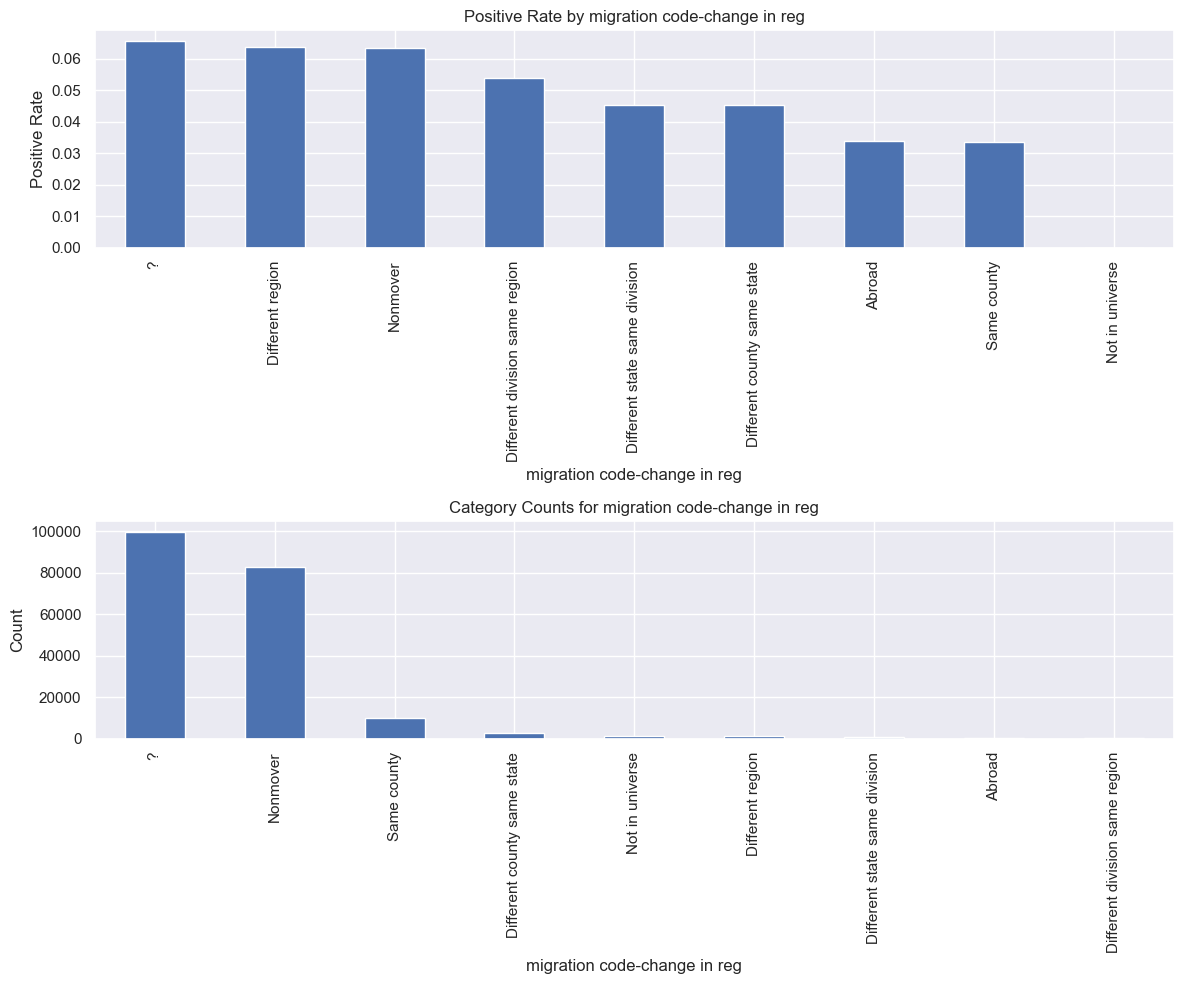

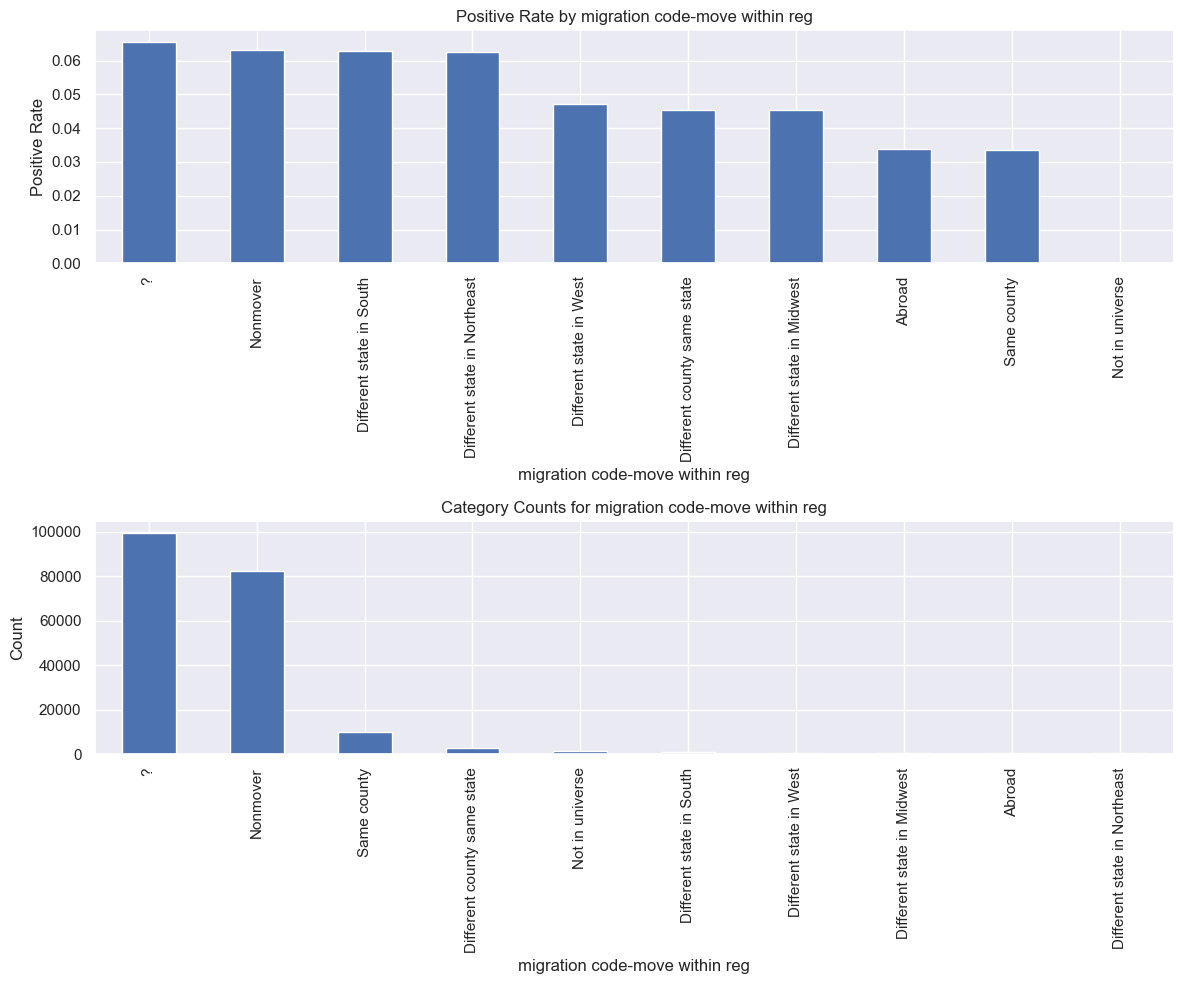

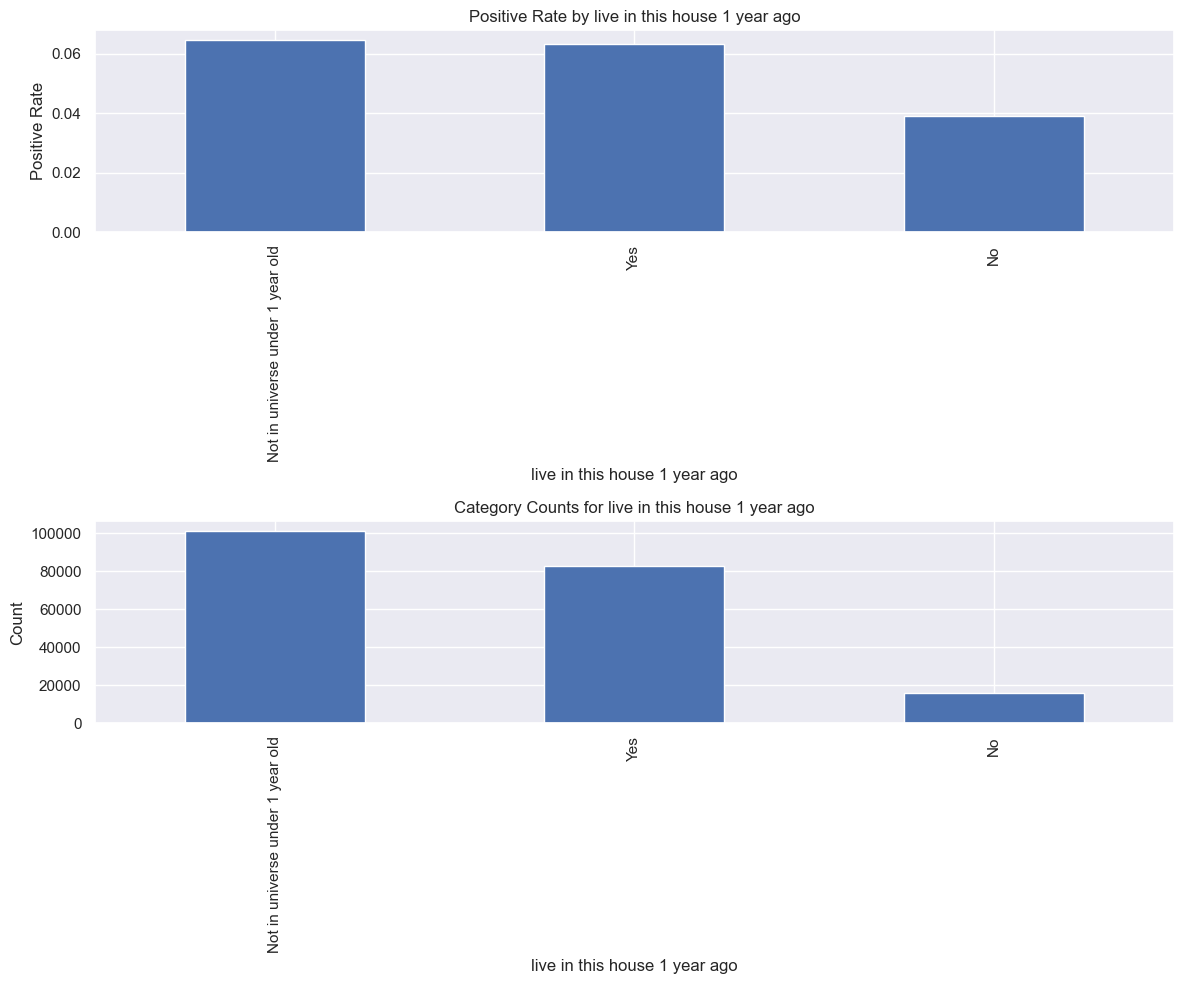

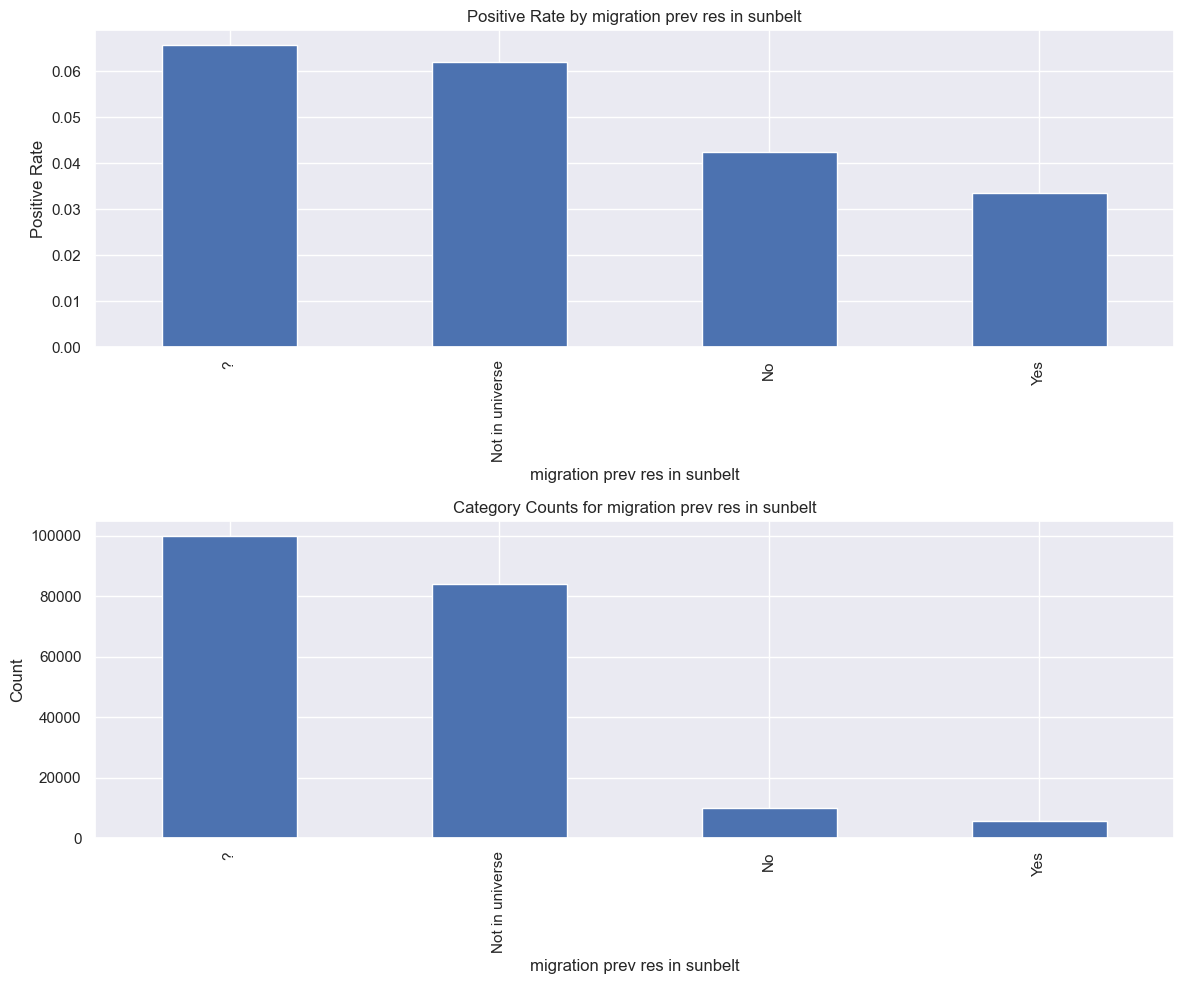

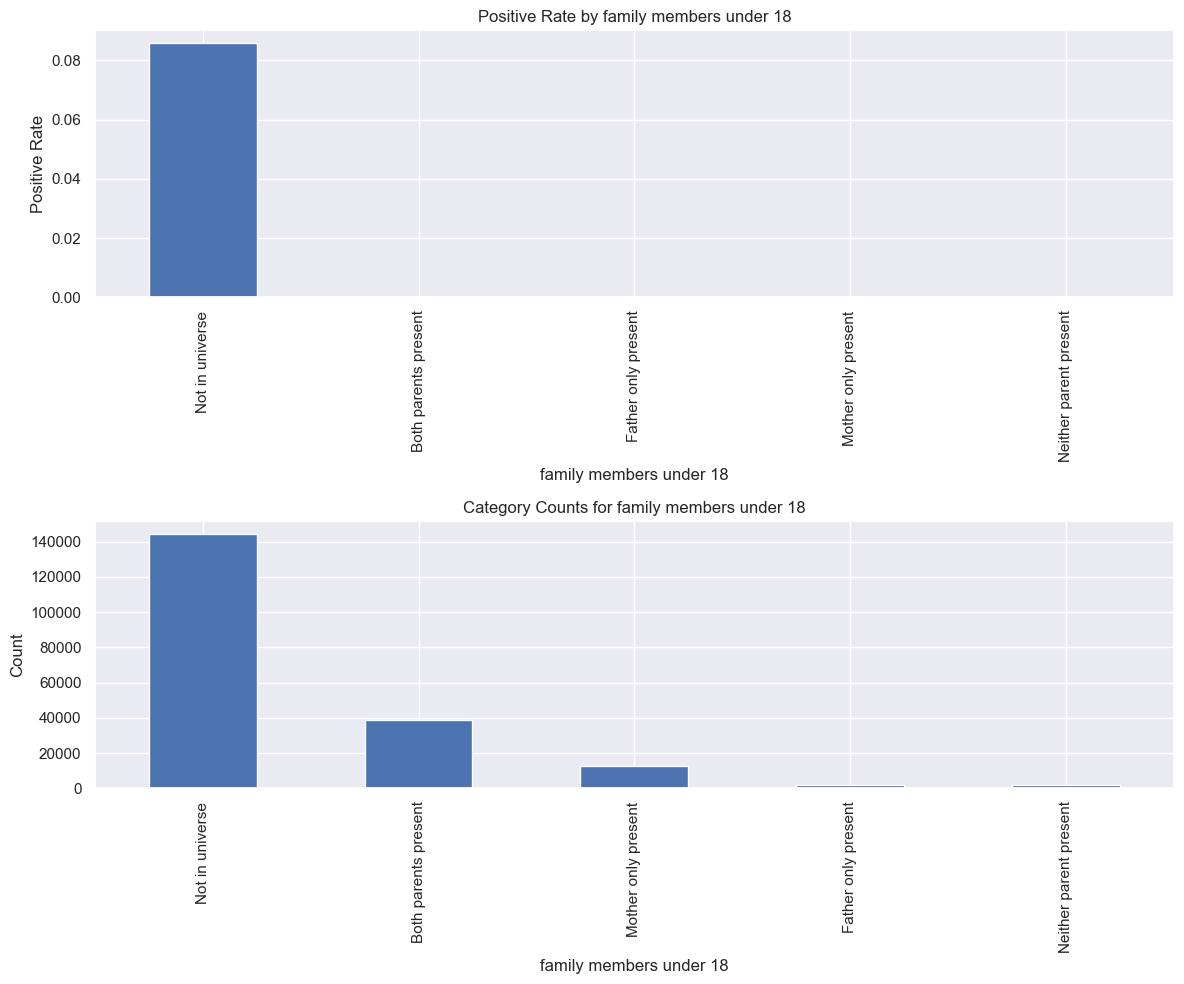

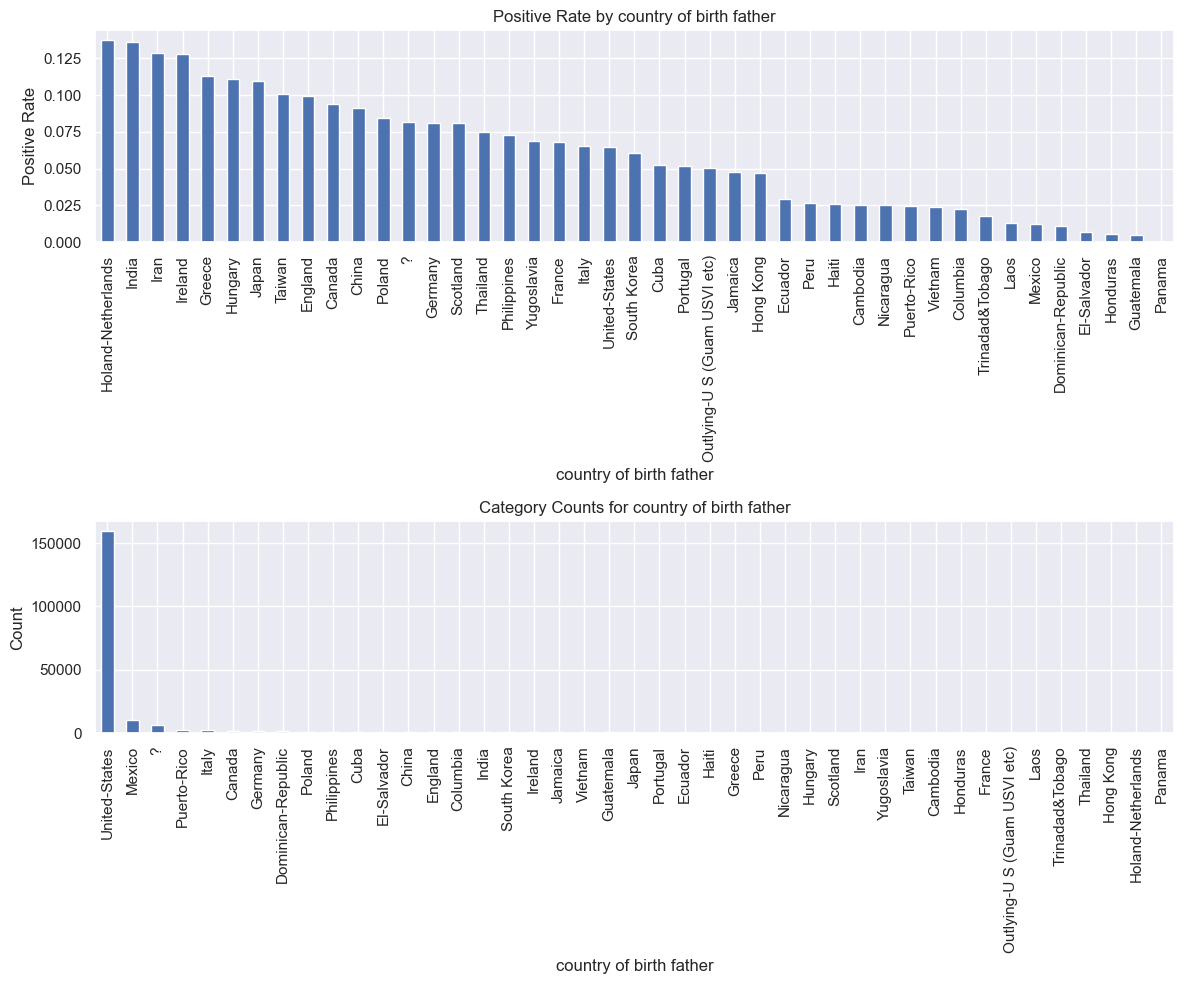

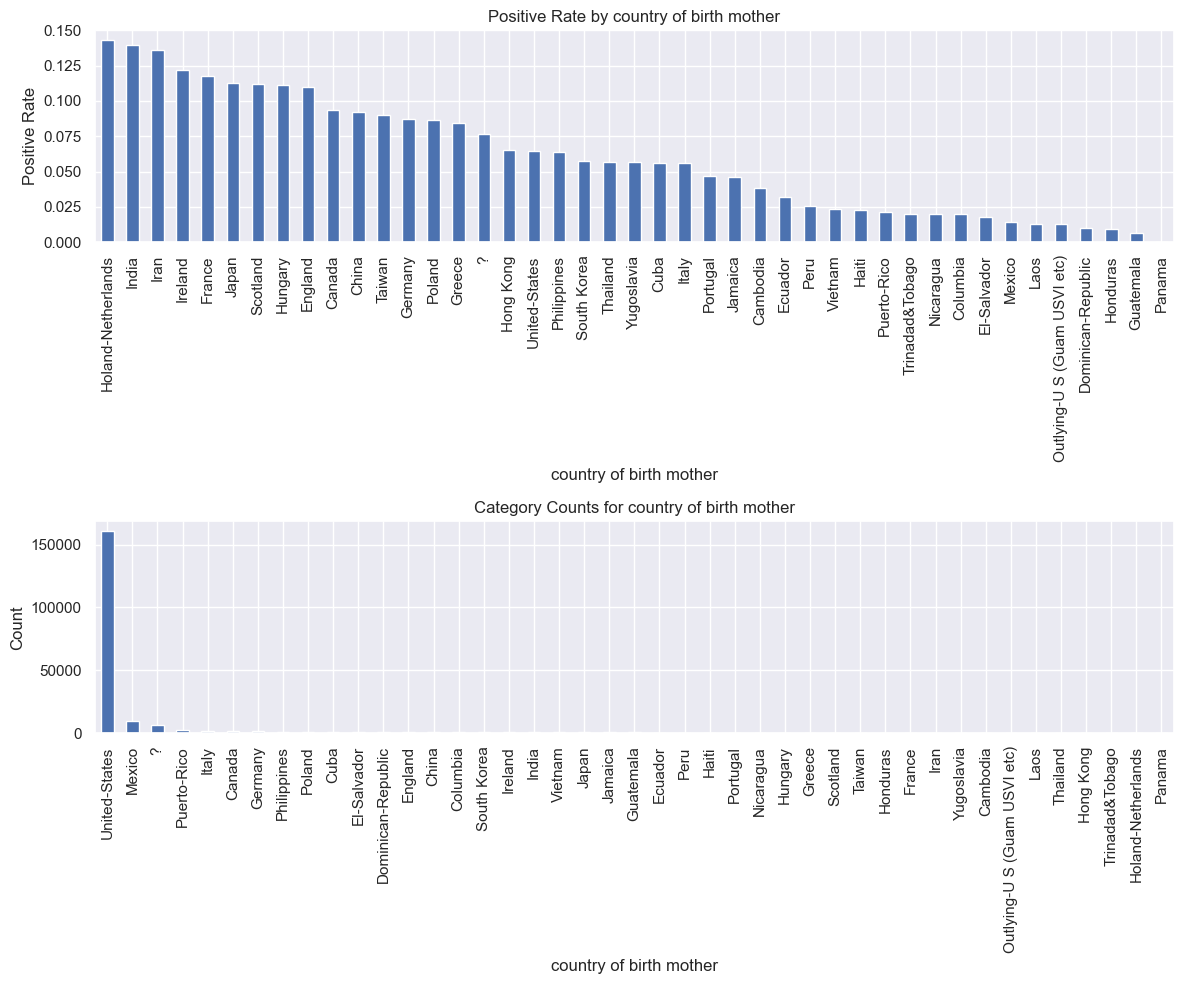

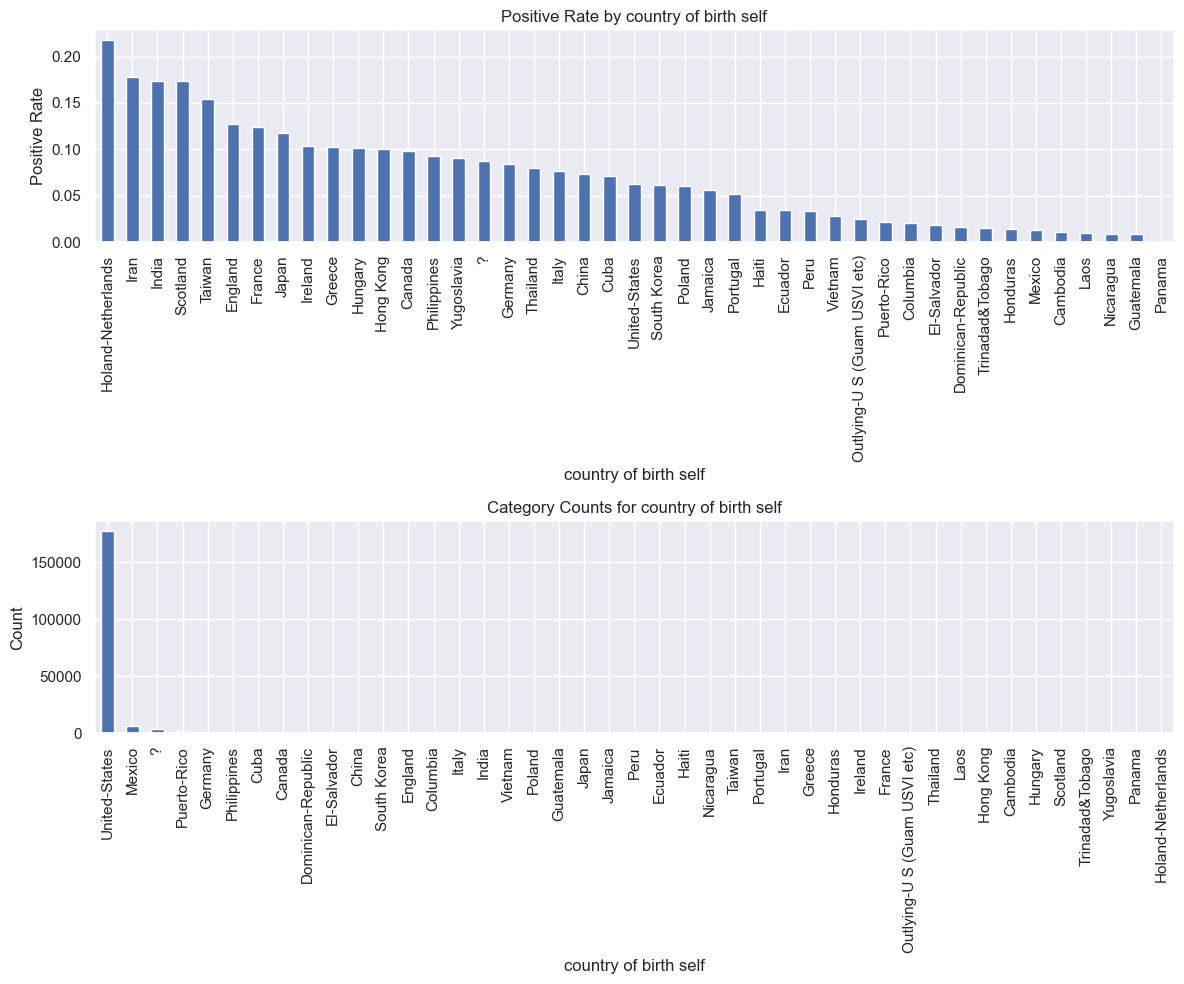

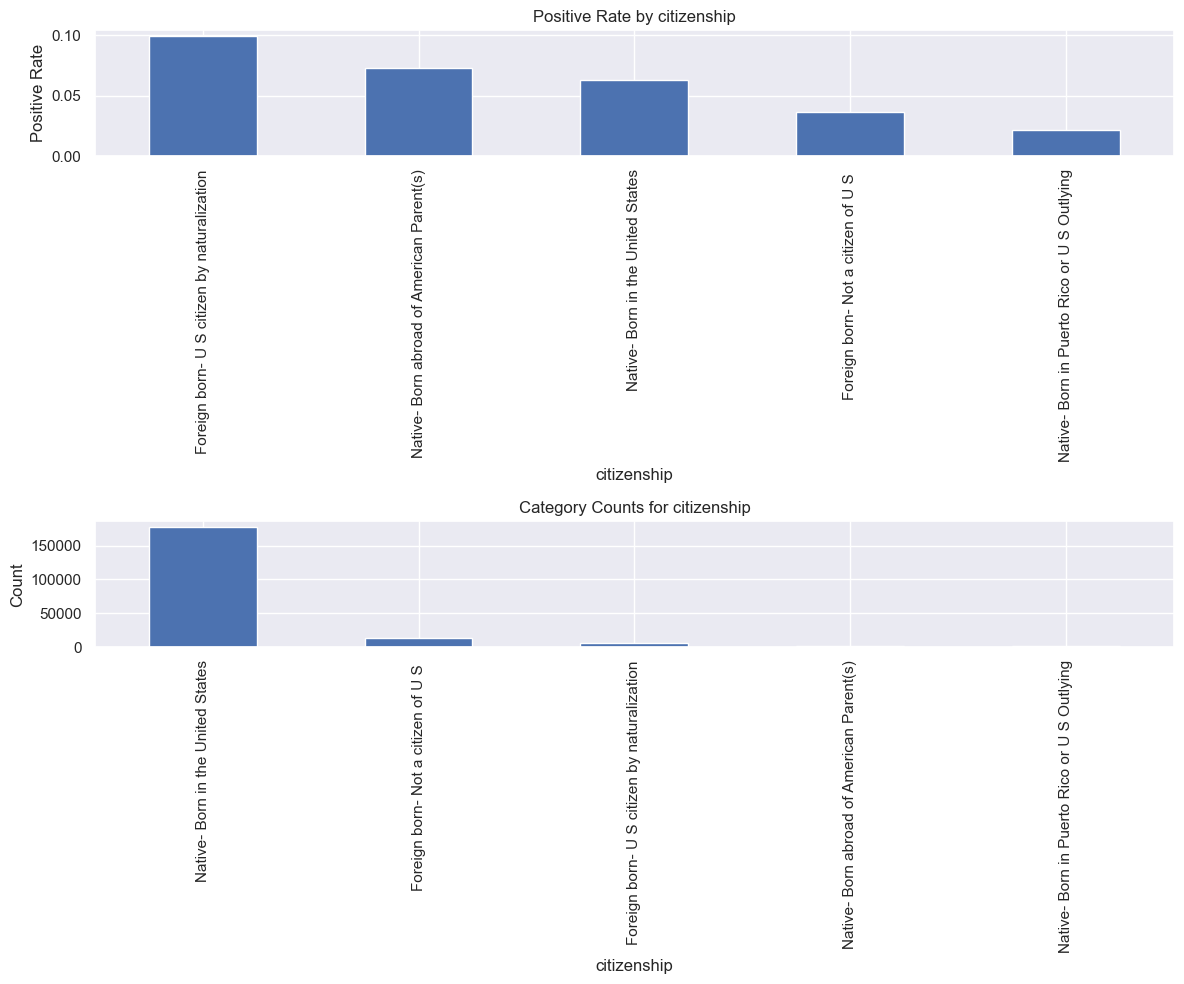

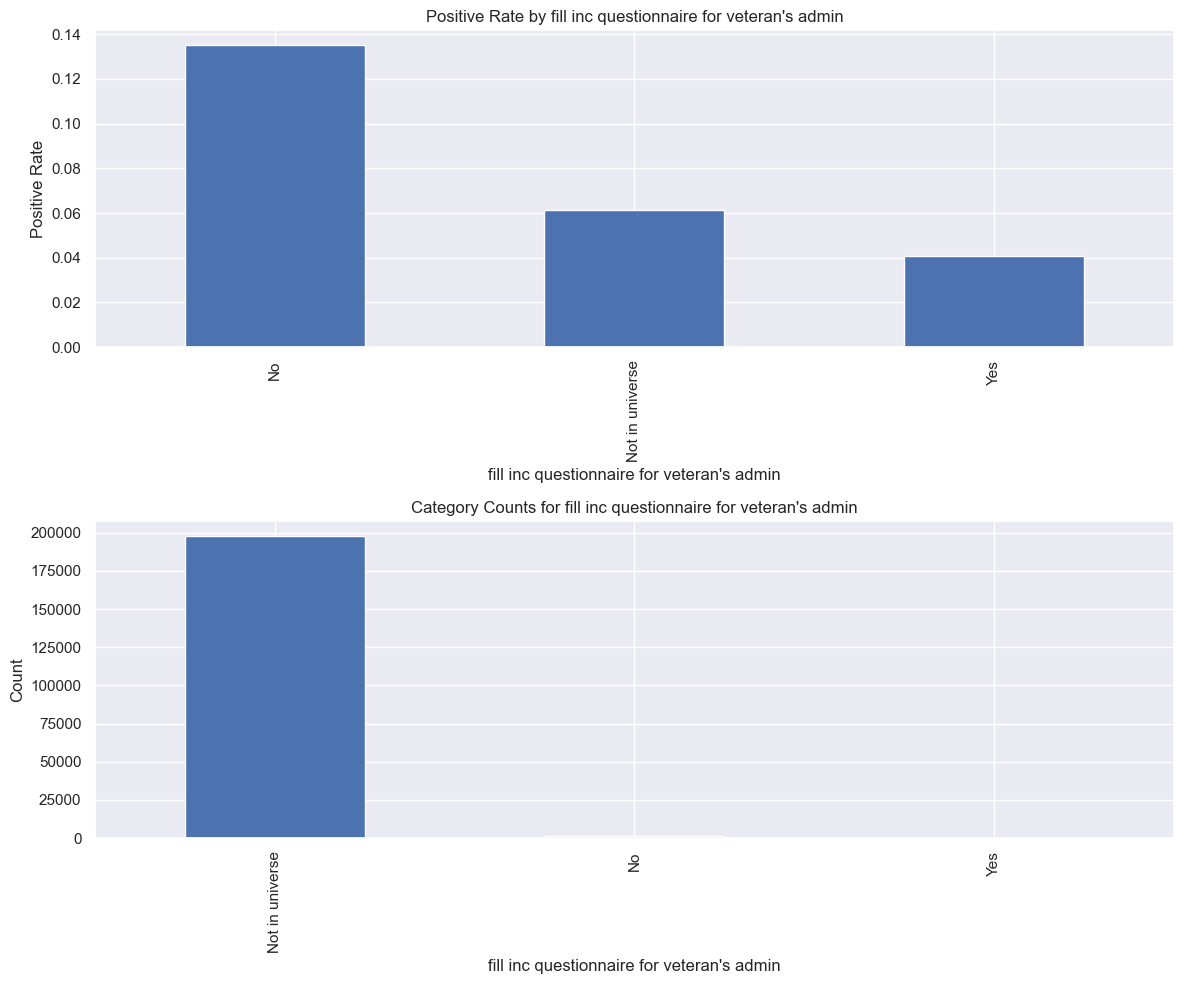

In [6]:
# Select categorical columns (excluding original label)
categorical_cols = df.select_dtypes(include=['object']).columns.drop('label')

# Analyze categorical features
for col in categorical_cols:
    # Calculate positive rate by category
    pos_rate = df.groupby(col)['label_bin'].mean().sort_values(ascending=False)
    counts = df[col].value_counts()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot positive rate
    pos_rate.plot(kind='bar', ax=ax1)
    ax1.set_title(f'Positive Rate by {col}')
    ax1.set_ylabel('Positive Rate')
    
    # Plot category counts
    counts.plot(kind='bar', ax=ax2)
    ax2.set_title(f'Category Counts for {col}')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.savefig(VIZ_DIR / f'{col}_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

## Missing Values Analysis

Missing Values Analysis:
                 Count  Percentage
hispanic origin    874        0.44


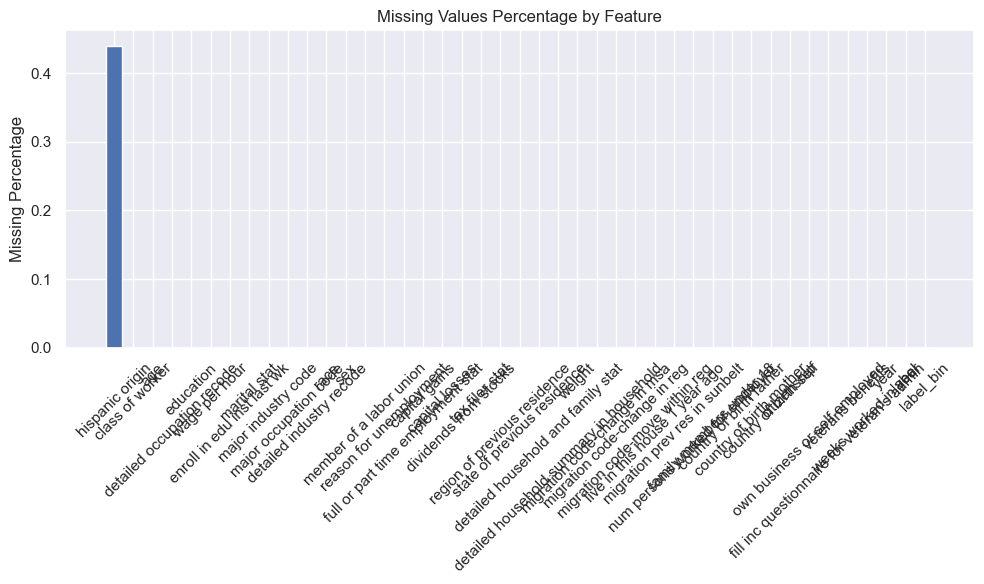

In [7]:
# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print('Missing Values Analysis:')
print(missing_df[missing_df['Count'] > 0])

# Visualize missing values
plt.figure(figsize=(10, 6))
plt.bar(range(len(missing_pct)), missing_pct)
plt.xticks(range(len(missing_pct)), missing.index, rotation=45)
plt.title('Missing Values Percentage by Feature')
plt.ylabel('Missing Percentage')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'missing_values.png', dpi=300, bbox_inches='tight')
plt.show()